# Monkey Functions
- 1.) Make pipeline for predictions
- 2.) Cycle through all the features and make predictions 
- 3.) Make software that allows for the user to enter the following and get preditctions out of it (i.e. train on all data and get novel predictions - dramatic presentation)
    - Age
    - Sex
    - Dose
    - Time since Irradiation
- 4.) Incorporate optimization in the pipeline
- 5.) Pipeline for health outcomes
    - able to cycle through as well

In [3]:
### Using monkey_env/ ###

# handling data
import pandas as pd
import numpy as np
import datetime

# visualizing data
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

# Statistics
from scipy import stats
import matplotlib.gridspec as gridspec
import math
import random


#SHAP Value stuff
import shap
from shap import TreeExplainer
from shap import GradientExplainer
from shap import DeepExplainer
from shap import KernelExplainer
from shap import SamplingExplainer
from shap import PartitionExplainer

#ML stuff
import catboost
from catboost import CatBoostClassifier, Pool, CatBoostRegressor, CatBoost
from catboost import Pool

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

import catboost as cb
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#fix the error that pops up about ipwydgets 
from tqdm import tqdm
#from .autonotebook import tqdm as notebook_tqdm

import warnings
warnings.filterwarnings("ignore")

print("Setup Complete")


/Users/aidanlew/Desktop/cmb/codes/monkey_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup Complete


In [5]:
cd '/Users/aidanlew/Documents'

/Users/aidanlew/Documents


In [6]:
def parser(x):
    return datetime.datetime.strptime(x,'%d-%m-%y')


# Predicting Biomarker Levels and Health Outcomes

## Data loading

In [7]:
# Make a df of the binary health data of the monkeys
minhealth_monkey_df = pd.read_excel('../Documents/demographic_data_r2.xlsx',
                    sheet_name=2,
                    skiprows = 0,
                    #usecols = ,
                    engine = 'openpyxl',
                    date_parser=parser
                         )

minhealth_monkey_df['Animal_Status'] = minhealth_monkey_df['Animal_Status'].map({'LIVING':1, 'DECEASED': 0})
#minhealth_monkey_df.head(15)
minhealth_monkey_df.columns


Index(['ID', 'Time_Under_Observation_(yrs)', 'Dose_(Gy)', 'Irrad_Age_(months)',
       'Years_Since_Irrad', 'Current_Age_(years)', 'Animal_Status',
       'Diabetes_(Y/N)', 'Cataracts_(Y/N)', 'Arthritis_(Y/N)',
       'Periodontitis_(Y/N)', 'GI_(Y/N)', 'Behavior_(Y/N)', 'Tumor_(Y/N)',
       'Heart_(Y/N)', 'Hypertension_(Y/N)', 'Testicular Atrophy_(Y/N)',
       'Ovarian Dysfunction_(Y/N)', 'Hepatic_(Y/N)', 'Kidney_(Y/N)',
       'Lung_(Y/N)', 'Bone_(Y/N)', 'Overweight_(Y/N)', 'Underweight_(Y/N)',
       'Brain Lesion_(Y/N)'],
      dtype='object')

In [8]:
# See our monkey sample size
print('Total Monkeys:{}'.format(minhealth_monkey_df['ID'].nunique()))
 
# Count the control monkeys
print('Non-Irradiated Monkeys:{}'.format(minhealth_monkey_df['Dose_(Gy)'].value_counts()[0]))
 
# Count the irradiated monkeys
#print('Irradiated Samples:{}'.format(minhealth_monkey_df['Dose_(Gy)'].value_counts()[!=0]))



Total Monkeys:152
Non-Irradiated Monkeys:32


In [9]:
#Make a df for the blood analytic data
minbio_monkey_df = pd.read_excel('../Documents/full_monkey_data_r2.xlsx',
                    #sheet_name=1,
                    skiprows = 0,
                    usecols = ['ID', 'Species', 'SAMPLE_DATE', 'IRRAD', 'IRRAD_DATE', 'DOB', 'SEX',
       'TYPE', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD',
       'DOSE_(Gy)', 'AGE', 'WBC_(K/uL)', 'RBC_(M/uL)', 'Hemaglobin_(HGB_g/dL)',
       'Hemocrit_(HCT_%)', 'Mean_corpuscular_volume_(MCV_fL)',
       'Mean_corpuscular_hemaglobin_(MCH_pg)',
       'Mean_corpuscular_hemaglobin_concentration_(MCHC_g/dL)', 'NEUT_(%)',
       'LYMPHOCYTES_(%)', 'MONO_(%)', 'EOS_(%)', 'BASO_(%)', 'ABS_NEUT_(/uL)',
       'ABS_LYMPH_(/uL)', 'ABS_MONO_(/uL)', 'ABS_EOS_(/uL)', 'ABS_BASO_(/uL)',
       'PLATLET_COUNT_(K/uL)'],
                    engine = 'openpyxl',
                    date_parser=parser
                         )

#Set the index to the monkey ID and make the labels not read as integers
minbio_monkey_df.set_index(['ID'])
minbio_monkey_df['ID'] = minbio_monkey_df['ID'].astype(str)

#minbio_monkey_df.dropna(axis=0, inplace=True) 

minbio_monkey_df.columns
#minbio_monkey_df.tail()


Index(['ID', 'Species', 'SAMPLE_DATE', 'IRRAD', 'IRRAD_DATE', 'DOB', 'SEX',
       'TYPE', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD',
       'DOSE_(Gy)', 'AGE', 'WBC_(K/uL)', 'RBC_(M/uL)', 'Hemaglobin_(HGB_g/dL)',
       'Hemocrit_(HCT_%)', 'Mean_corpuscular_volume_(MCV_fL)',
       'Mean_corpuscular_hemaglobin_(MCH_pg)',
       'Mean_corpuscular_hemaglobin_concentration_(MCHC_g/dL)', 'NEUT_(%)',
       'LYMPHOCYTES_(%)', 'MONO_(%)', 'EOS_(%)', 'BASO_(%)', 'ABS_NEUT_(/uL)',
       'ABS_LYMPH_(/uL)', 'ABS_MONO_(/uL)', 'ABS_EOS_(/uL)', 'ABS_BASO_(/uL)',
       'PLATLET_COUNT_(K/uL)'],
      dtype='object')

In [10]:
#Make a df were there is one monkey's data missing (the same in the single_monkey_df)
oneless_df = pd.read_excel('../Documents/full_monkey_data_r2.xlsx',
                    sheet_name=1,
                    skiprows = 0,
                    usecols = ['ID', 'Species', 'SAMPLE_DATE', 'IRRAD', 'IRRAD_DATE', 'DOB', 'SEX',
       'TYPE', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD',
       'DOSE_(Gy)', 'AGE', 'WBC_(K/uL)', 'RBC_(M/uL)', 'Hemaglobin_(HGB_g/dL)',
       'Hemocrit_(HCT_%)', 'Mean_corpuscular_volume_(MCV_fL)',
       'Mean_corpuscular_hemaglobin_(MCH_pg)',
       'Mean_corpuscular_hemaglobin_concentration_(MCHC_g/dL)', 'NEUT_(%)',
       'LYMPHOCYTES_(%)', 'MONO_(%)', 'EOS_(%)', 'BASO_(%)', 'ABS_NEUT_(/uL)',
       'ABS_LYMPH_(/uL)', 'ABS_MONO_(/uL)', 'ABS_EOS_(/uL)', 'ABS_BASO_(/uL)',
       'PLATLET_COUNT_(K/uL)'],
                    engine = 'openpyxl',
                    date_parser=parser
                         )

#Set the index to the monkey ID and make the labels not read as integers
oneless_df.set_index(['ID'])

oneless_df['ID'] = oneless_df['ID'].astype(str)

#oneless_dff.dropna(axis=0, inplace=True) 

#oneless_df.columns
oneless_df.tail()

,ID,Species,SAMPLE_DATE,IRRAD,IRRAD_DATE,DOB,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
4529,2112,Rhesus-Chinese,2020-09-23 00:00:00,No,NaT,1999-09-28,M,Research,NaN,NaN,...,67.0,6.2,1.1,0.0,1696,4422,409,73,0,289
4530,2112,Rhesus-Chinese,2021-03-04 00:00:00,No,NaT,1999-09-28,M,Research,NaN,NaN,...,56.1,9.1,1.5,0.0,1312,2210,359,59,0,284
4531,2210,Rhesus-Indian,2021-09-07 00:00:00,No,NaT,1999-01-01,F,Research,NaN,NaN,...,26.8,12.3,1.2,0.0,3104,1394,640,62,0,311
4532,2210,Rhesus-Indian,2021-09-20 00:00:00,No,NaT,1999-01-01,F,Research,NaN,NaN,...,36.2,10.9,1.7,0.0,2970,2100,632,99,0,348
4533,2210,Rhesus-Indian,2021-10-07 00:00:00,No,NaT,1999-01-01,F,Research,NaN,NaN,...,16.0,21.0,3.0,0.0,3360,896,1176,168,0,329


In [11]:
# Make a df of a single monkey's blood analytic data
single_minbio_df = minbio_monkey_df.copy()
single_minbio_df = single_minbio_df[single_minbio_df['ID'] == '2046']
single_minbio_df.set_index(['ID'])
#single_minbio_df.reset_index()
single_minbio_df.head()


,ID,Species,SAMPLE_DATE,IRRAD,IRRAD_DATE,DOB,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
33,2046,Rhesus-Chinese,2017-11-02,Yes,2014-04-09,2007-07-03,F,Clinical,1303.0,43.0,...,44.6,5.5,0.5,0.0,1877,1695,209,19,0,276
34,2046,Rhesus-Chinese,2017-12-13,Yes,2014-04-09,2007-07-03,F,Clinical,1344.0,44.0,...,40.5,7.4,0.0,0.0,3647,2835,518,0,0,386
35,2046,Rhesus-Chinese,2018-01-02,Yes,2014-04-09,2007-07-03,F,Research,1364.0,45.0,...,39.9,6.0,0.3,0.3,2140,1596,240,12,12,309
36,2046,Rhesus-Chinese,2018-01-31,Yes,2014-04-09,2007-07-03,F,Research,1393.0,46.0,...,46.8,5.6,0.5,0.0,2025,2012,241,22,0,275
37,2046,Rhesus-Chinese,2018-04-05,Yes,2014-04-09,2007-07-03,F,Research,1457.0,48.0,...,22.8,5.8,0.1,0.1,6123,1961,499,9,9,325


# PLOTTING FUNCTION 

In [12]:
### Automate predictions and plotting predictions

def predict_and_plot(model, X_validation, y_validation, y):
    
    ### Predictions ###
    a = model.predict(X_validation)
    a_df = pd.DataFrame(a)
    
    ### Plotting ###
    # Plot the predictions
    fig, ax = plt.subplots()
    ax.scatter(y_validation, a_df)

    ax.plot([y.min(), y.max()], [y.min(), y.max()], 
            'k-', 
            linewidth=1, 
            markersize=120
    )
    
    #Plot axis titles
    ax.set_xlabel('Actual {}'.format(str(ylabel)))
    ax.set_ylabel('Predicted {}'.format(str(ylabel)))

    #Title of the plot
    plot_title = input("Plot Title:")
    show_iters = model.get_param('iterations')  
    ax.set_title(plot_title + "\nIterations: {}".format(str(show_iters))
                 ,fontsize=15
    )
   
    #cordinates for the R2 value box
    xmin, xmax, ymin, ymax = plt.axis()
    yrange = ymax-ymin
    xrange = xmax-xmin

            
    #Plotting the R2 score and MSE
    ax.annotate("R2: {}".format(str(r2_score(y_validation, a_df).round(2)))+'\nMSE: {}'.format(str(mean_squared_error(y_validation, a_df).round(2))),
                xy=((xmin+(0.1*(xrange))),(ymax-(0.15*(yrange)))), 
                fontsize=12,
                bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}
    )

    
    #Save the plot
    fig_name = input('Figure name')
    plt.savefig("%s.pdf" % fig_name, dpi=900, bbox_inches='tight')
    
    ### Feature Importance ###

    feat = model.get_feature_importance(data=pool,
                       prettified=True,

    )
    
    print(feat)
    
    #print('MSE: {}'.format(mean_squared_error(y_validation, a_df)))

# MODEL FUCTION

In [13]:
### Form a regression model with custom inputs

def regression_model_formation (X,y,cat_features):
    model = input('Model Name')
    iterations = float(input('Iterations'))
    learning_rate = float(input('Learning Rate'))
    early_stopping_rounds = float(input('Stopping Rounds'))
    
    model = CatBoostRegressor(iterations=iterations, 
                              learning_rate=learning_rate,
                               early_stopping_rounds= early_stopping_rounds
                             )
    model.fit(X,y,cat_features=cat_features  
         )

# MODEL, PREDICT, AND PLOT FUNCTION

In [14]:
### function to form a regression model, predict, and plot predictions

def model_pred_plot (X, y, cat_features, X_validation, y_validation):
    ### Model Formation ###
    model = input('Model Name')
    iterations = float(input('Iterations'))
    learning_rate = float(input('Learning Rate'))
    early_stopping_rounds = float(input('Stopping Rounds'))
    
    model = CatBoostRegressor(iterations=iterations, 
                              learning_rate=learning_rate,
                               early_stopping_rounds= early_stopping_rounds
                             )
    model.fit(X,y,cat_features=cat_features  
         )

    ### Predictions ###
    a = model.predict(X_validation)
    a_df = pd.DataFrame(a)


    # Plot the predictions
    fig, ax = plt.subplots()
    ax.scatter(y_validation, a_df)

    ax.plot([y.min(), y.max()], [y.min(), y.max()], 
            'k-', 
            linewidth=1, 
            markersize=120
    )
    
    ### Plotting ###
    
    #Plot axis titles
    xlab = input("X axis name:")
    ylab = input("Y axis name:")
    
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)

    #Title of the plot
    plot_title = input("Plot Title:")
    show_iters = model.get_param('iterations')  
    ax.set_title(plot_title + "\nIterations: {}".format(str(show_iters))
                 ,
                 fontsize=15
    )
    
    #cordinates for the R2 value box
    xmin, xmax, ymin, ymax = plt.axis()
    yrange = ymax-ymin
    xrange = xmax-xmin

            
    #Plotting the R2 score and MSE
    ax.annotate("R2: {}".format(str(r2_score(y_validation, a_df).round(2)))+'\nMSE: {}'.format(str(mean_squared_error(y_validation, a_df).round(2))),
                xy=((xmin+(0.1*(xrange))),(ymax-(0.15*(yrange)))), 
                fontsize=12,
                bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}
    )
   
    #Save the plot
    fig_name = input('Figure name')
    plt.savefig("%s.pdf" % fig_name, dpi=900, bbox_inches='tight')
    
    

# DATA SETUP FUNCTION

In [15]:
### automate data setup for ML

def data_setup (df):
  ##################### for this to work, the catagorical features need to be all to the left side of the df ####################
    
    ### Data Setup ###
    
    (train_df, test_df)= df, df 
    
    #data labeling
    global X, y, ylabel
    ylabel = input('Target Feature Column:')  
    y = df[ylabel]
    X = df.drop(['ID',ylabel],axis=1)
    
    #declare catagorical features
    global cat_features
    cat_cols = int(input('How many catagorical columns:'))
    cat_features= list(range(0,X[X.columns[:cat_cols]].shape[1]))
    
    #put data into pool
    global pool
    pool = Pool(data=X, label=y, cat_features=cat_features)
    
    #train tesr split - 30% test
    test_size = float(input('Test Size'))
    data= train_test_split(X, y, test_size=test_size, random_state=0)

    #The order of this matters#
    global  X_train, X_validation, y_train, y_validation
    X_train, X_validation, y_train, y_validation= data
    
    global train_pool
    train_pool = Pool(
        data = X_train,
        label = y_train,
        cat_features = cat_features
    )
    
    global validation_pool
    validation_pool = Pool(
        data = X_validation,
        label = y_validation,
        cat_features = cat_features
    )


# PIPELINE FOR REGRESSION


In [46]:
### pipeline for regression - data to plotting

def regression_pipeline (df):
    ##################### for this to work, the catagorical features need to be all to the left side of the df ####################
    
    ### Data Setup ###
    
    (train_df, test_df)= df, df 
    
    #data labeling
    ylabel = input('Target Feature Column:')  
    y = df[ylabel]
    X = df.drop(['ID',ylabel],axis=1)
    
    #declare catagorical features
    cat_cols = int(input('How many catagorical columns:'))
    cat_features= list(range(0,X[X.columns[:cat_cols]].shape[1]))
    
    #put data into pool
    pool = Pool(data=X, label=y, cat_features=cat_features)
    
    #train tesr split - 30% test
    test_size = float(input('Test Size'))
    data= train_test_split(X, y, test_size=test_size, random_state=0)

    #The order of this matters#
    X_train, X_validation, y_train, y_validation= data

    train_pool = Pool(
        data = X_train,
        label = y_train,
        cat_features = cat_features
    )
    

    validation_pool = Pool(
        data = X_validation,
        label = y_validation,
        cat_features = cat_features
    )
    
    ### Model Formation ###
    iterations = float(input('Iterations:'))
    learning_rate = float(input('Learning Rate:'))
    early_stopping_rounds = float(input('Stopping Rounds:'))
    
    model = CatBoostRegressor(iterations=iterations, 
                              learning_rate=learning_rate,
                               early_stopping_rounds= early_stopping_rounds
                             )
    model.fit(X_train, y_train,
              cat_features=cat_features,
              verbose=False
         )

    ### Predictions ###
    a = model.predict(X_validation)
    a_df = pd.DataFrame(a)

   
    ### Plotting ###
    # Plot the predictions
    fig, ax = plt.subplots()
    ax.scatter(y_validation, a_df)

    ax.plot([y.min(), y.max()], [y.min(), y.max()], 
            'k-', 
            linewidth=1, 
            markersize=120
    )
    
    #Plot axis titles
    ax.set_xlabel('Actual {}'.format(str(ylabel)))
    ax.set_ylabel('Predicted {}'.format(str(ylabel)))

    #Title of the plot
    plot_title = input("Plot Title:")
    #show_iters = model.get_param('iterations')  
    ax.set_title(plot_title #+ "\nIterations: {}".format(str(show_iters))
                 ,fontsize=15
    )
   
    #cordinates for the R2 value box
    xmin, xmax, ymin, ymax = plt.axis()
    yrange = ymax-ymin
    xrange = xmax-xmin

            
    #Plotting the R2 score and MSE
    ax.annotate("R2: {}".format(str(r2_score(y_validation, a_df).round(2)))+'\nMSE: {}'.format(str(mean_squared_error(y_validation, a_df).round(2))),
                xy=((xmin+(0.1*(xrange))),(ymax-(0.15*(yrange)))), 
                fontsize=12,
                bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}
    )
    
    #Save the plot
    fig_name = input('Figure name')
    plt.savefig("catboost_%s.pdf" % fig_name, dpi=900, bbox_inches='tight')

    ### Feature Importance ###

    feat = model.get_feature_importance(data=pool,
                       prettified=True,

    )
    
    print(feat)
    

# HEALTH OUTCOME PIPELINE

In [72]:
### Pipeline for claassification - data to plotting

def classifier_pipeline (df):
    ##################### for this to work, the catagorical features need to be all to the left side of the df ####################
    
    ### Data Setup ###
    
    (train_df, test_df)= df, df 
    
    #data labeling
    ylabel = input('Target Feature Column:')  
    y = df[ylabel]
    X = df.drop(['ID',ylabel],axis=1)
    
    #declare catagorical features
    cat_cols = int(input('How many catagorical columns:'))
    cat_features= list(range(0,X[X.columns[:cat_cols]].shape[1]))
    
    #put data into pool
    pool = Pool(data=X, label=y, cat_features=cat_features)
    
    #train tesr split - 30% test
    test_size = float(input('Test Size'))
    data= train_test_split(X, y, test_size=test_size, random_state=0)

    #The order of this matters#
    X_train, X_validation, y_train, y_validation= data

    train_pool = Pool(
        data = X_train,
        label = y_train,
        cat_features = cat_features
    )

    validation_pool = Pool(
        data = X_validation,
        label = y_validation,
        cat_features = cat_features
    )
    
    ### Model Formation ###
    iterations = float(input('Iterations:'))
    learning_rate = float(input('Learning Rate:'))
    early_stopping_rounds = float(input('Stopping Rounds:'))
    
    model = CatBoostClassifier(iterations=iterations, 
                              learning_rate=learning_rate,
                               loss_function='Logloss',
                               custom_loss=['AUC','Accuracy'],
                               early_stopping_rounds= early_stopping_rounds
    )
   

    model.fit(X_train, y_train, 
              cat_features=cat_features, 
              verbose=False  
    )

    ### Predictions ###
    a = model.predict(X_validation)
    a_df = pd.DataFrame(a)

    ### Plotting ###
    # make confusion matrix
    cm = confusion_matrix(y_validation, a_df)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  #display_labels=clf.classes_
                                 )
    disp.plot()
    plt.grid(False)


    Accuracy = metrics.accuracy_score(y_validation, a_df)
    Precision = metrics.precision_score(y_validation, a_df)

    
    #Save the plot
    fig_name = input('Figure name')
    plt.savefig("%s.pdf" % fig_name, dpi=900, bbox_inches='tight')

    
    print('Accuracy:',Accuracy, 'Precision:',Precision)
    print(classification_report(y_validation, a_df))

# OPTOMIZED REGRESSION

In [28]:
### Tell Optuna what parameters to test

def objective(trial):
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    param = {
        "loss_function": trial.suggest_categorical("loss_function", ["RMSE", "MAE"]),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e0),
        #"iterations" : trial.suggest_int("iterations", 1, 100000),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 1e0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 20),
        "one_hot_max_size": trial.suggest_int("one_hot_max_size", 2, 20),  
    }
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    model = cb.CatBoostRegressor(**param, iterations=1000, early_stopping_rounds=5)

    model.fit(X_train, y_train, cat_features=cat_features, eval_set=[(X_validation, y_validation)], verbose=0, early_stopping_rounds=100)

    a = model.predict(X_validation)
    a_df = pd.DataFrame(a)
    accuracy = r2_score(y_validation, a)
    return accuracy


In [29]:
### regression pipeline with built-in optomization

def opomized_regression_pipeline (df):
    ##################### for this to work, the catagorical features need to be all to the left side of the df ####################
    
    data_setup(df)
    
    opq = int(input('Do you want this potomized? (1/0)'))
    
    if opq == 1:
        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=50, timeout=600)
        trial = study.best_trial
        
        model = CatBoostRegressor(**trial.params)
        model.fit(X_train, y_train, cat_features=cat_features, verbose=False)
        
        predict_and_plot(model, X_validation, y_validation, y)
        
    else: 
        ### Model Formation ###
        iterations = float(input('Iterations:'))
        learning_rate = float(input('Learning Rate:'))
        early_stopping_rounds = float(input('Stopping Rounds:'))

        model = CatBoostRegressor(iterations=iterations, 
                                  learning_rate=learning_rate,
                                   early_stopping_rounds= early_stopping_rounds
                                 )
        model.fit(X_train, y_train,
                  cat_features=cat_features,
                  verbose=False
             )

        predict_and_plot(model, X_validation, y_validation, y)

# CLASSIFYER CYCLER

In [90]:
### function to cycle through the health outcomes

def classification_cycler (df):
    avoid_list = ['ID', 'Time_Under_Observation_(yrs)', 'Dose_(Gy)', 'Irrad_Age_(months)',
       'Years_Since_Irrad', 'Current_Age_(years)']
    
    cat_cols = int(input('How many catagorical columns:'))
    
    for (columnName, columnData) in df.iteritems():
        if columnName in avoid_list:
            continue
        else:  
    
            ### Data Setup ###

            (train_df, test_df)= df, df 

            #data labeling
            ylabel = columnName
            y = df[ylabel]
            X = df.drop(['ID',ylabel],axis=1)

            #declare catagorical features
            cat_features= list(range(0,X[X.columns[:cat_cols]].shape[1]))

            #put data into pool
            pool = Pool(data=X, label=y, cat_features=cat_features)

            #train tesr split - 30% test
            data= train_test_split(X, y, test_size=0.3, random_state=0)

            #The order of this matters#
            X_train, X_validation, y_train, y_validation= data

            train_pool = Pool(
                data = X_train,
                label = y_train,
                cat_features = cat_features
            )

            validation_pool = Pool(
                data = X_validation,
                label = y_validation,
                cat_features = cat_features
            )

            model = CatBoostClassifier(iterations=1000, 
                                      learning_rate=0.5,
                                       loss_function='Logloss',
                                       custom_loss=['AUC','Accuracy'],
                                       early_stopping_rounds=5
            )

            model.fit(X_train, y_train, 
                      cat_features=cat_features, 
                      verbose=False  
            )

            ### Predictions ###
            a = model.predict(X_validation)
            a_df = pd.DataFrame(a)

            ### Plotting ###
            
            # make confusion matrix
            cm = confusion_matrix(y_validation, a_df)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                          #display_labels=clf.classes_
                                         )
            disp.plot()
            plt.grid(False)


            Accuracy = metrics.accuracy_score(y_validation, a_df)
            Precision = metrics.precision_score(y_validation, a_df)
            print('Accuracy:',Accuracy, 'Precision:',Precision)
            print(classification_report(y_validation, a_df))
            print(ylabel)

How many catagorical columns: 0


Accuracy: 0.8695652173913043 Precision: 0.8333333333333334
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        24
           1       0.83      0.91      0.87        22

    accuracy                           0.87        46
   macro avg       0.87      0.87      0.87        46
weighted avg       0.87      0.87      0.87        46

Animal_Status
Accuracy: 0.8478260869565217 Precision: 0.4
              precision    recall  f1-score   support

           0       0.90      0.93      0.91        40
           1       0.40      0.33      0.36         6

    accuracy                           0.85        46
   macro avg       0.65      0.63      0.64        46
weighted avg       0.84      0.85      0.84        46

Diabetes_(Y/N)
Accuracy: 0.6521739130434783 Precision: 0.7333333333333333
              precision    recall  f1-score   support

           0       0.61      0.83      0.70        23
           1       0.73      0.48      0.58   

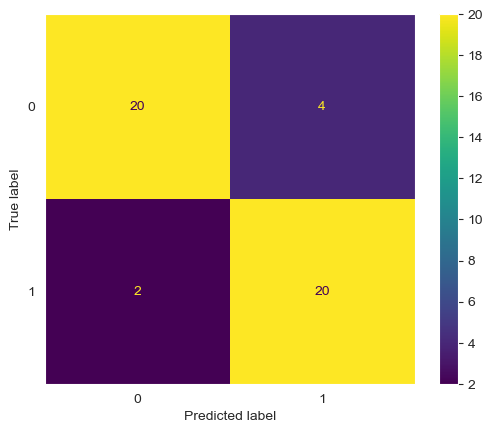

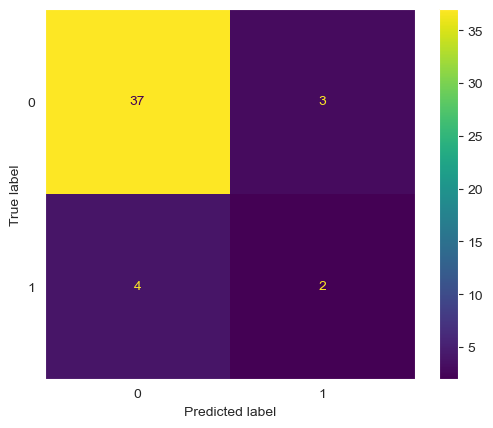

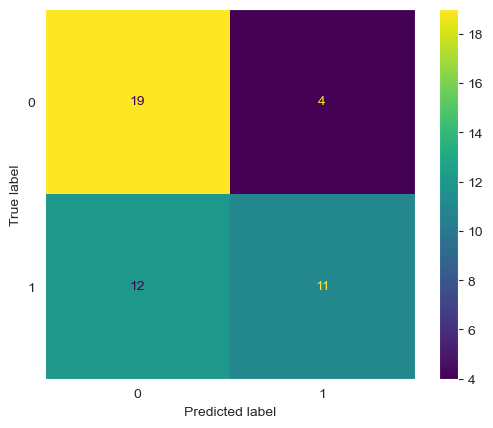

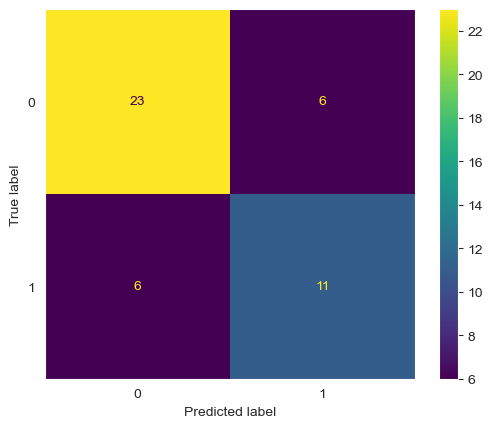

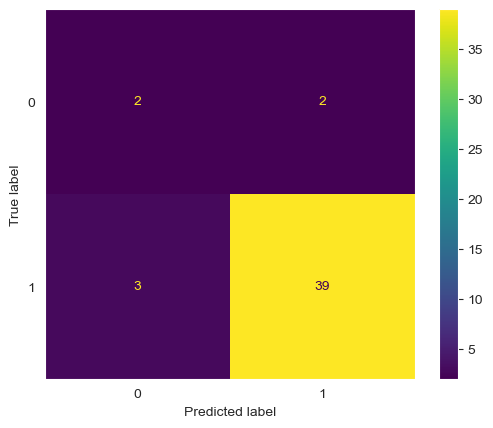

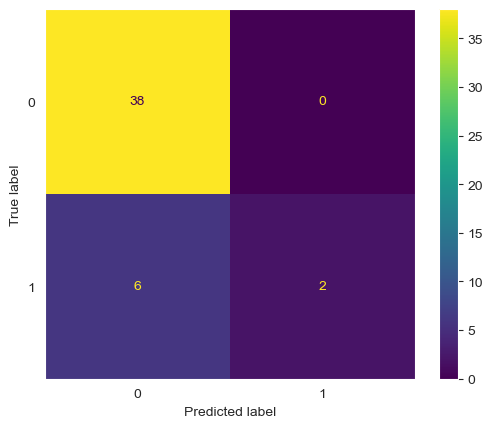

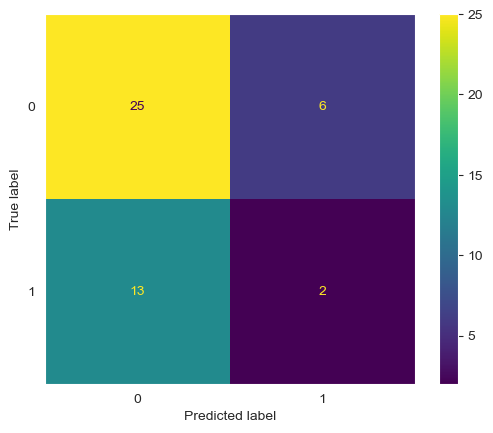

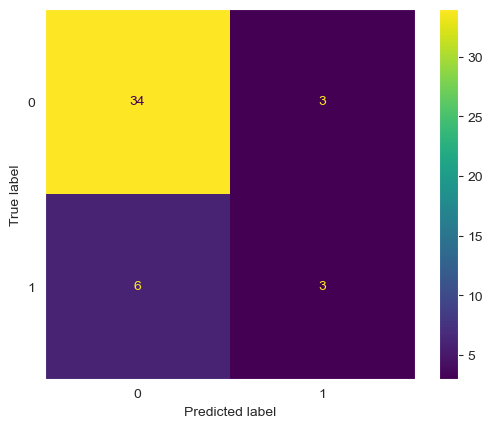

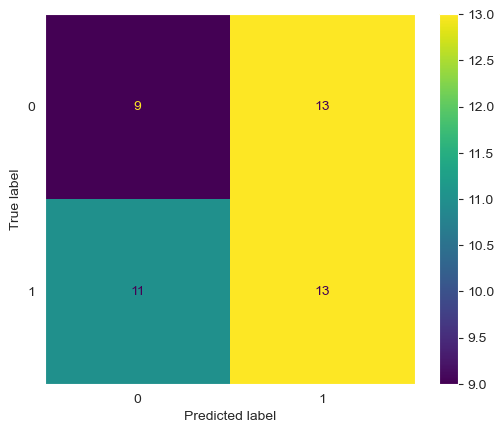

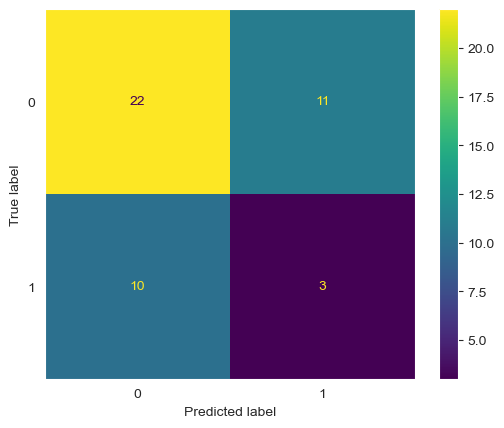

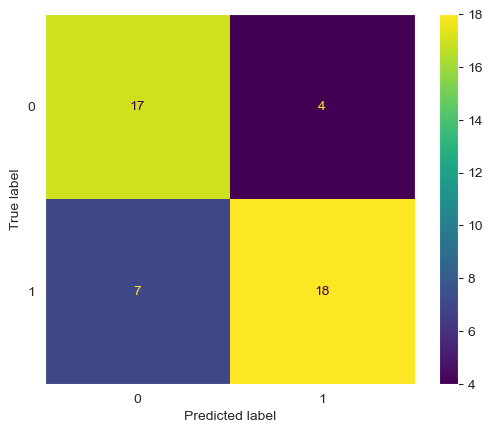

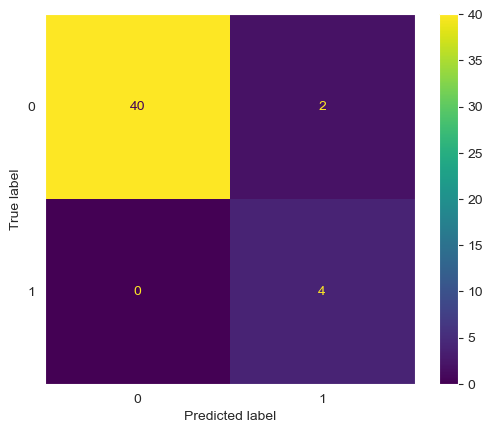

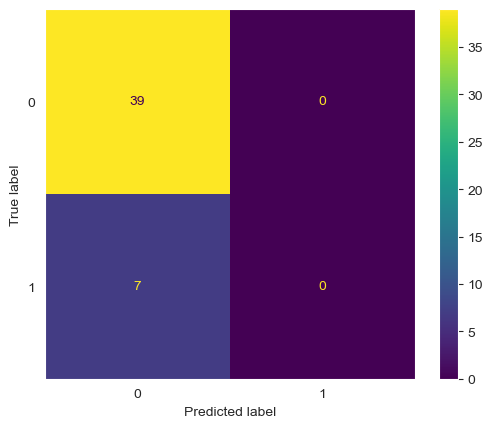

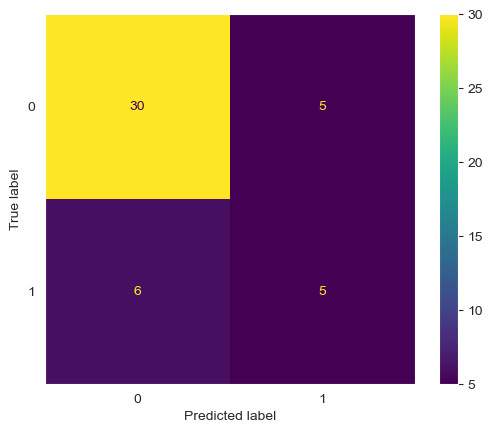

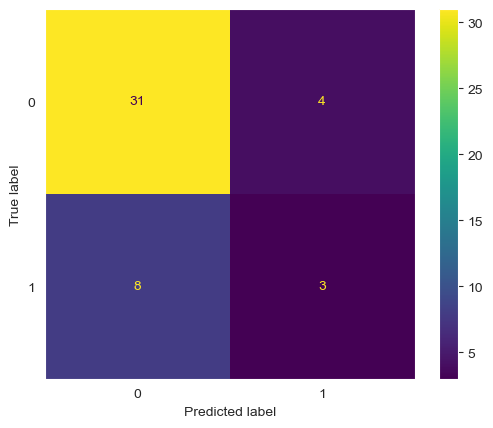

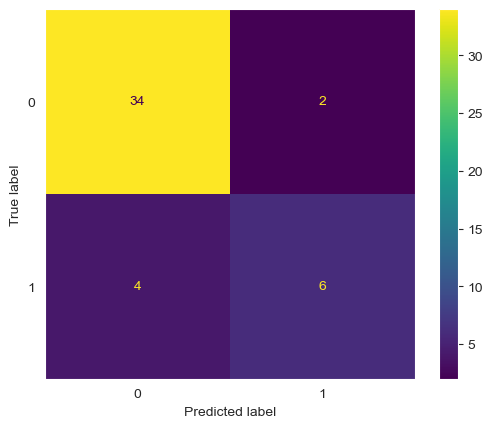

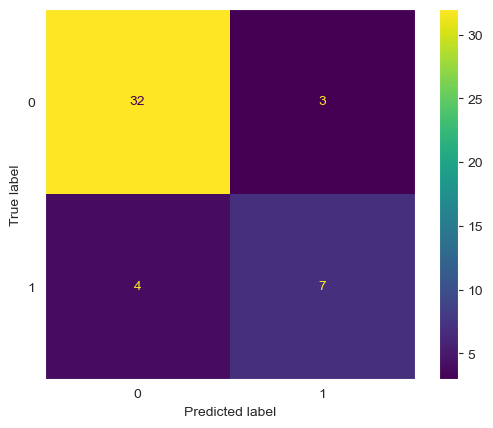

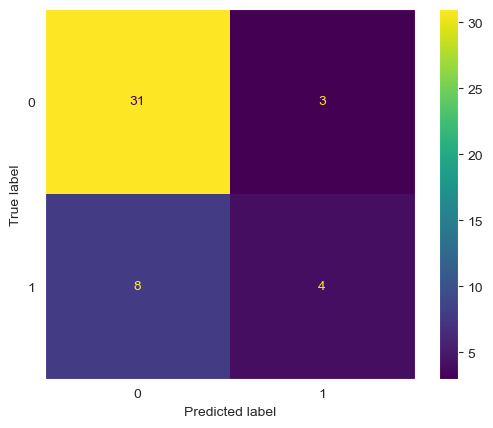

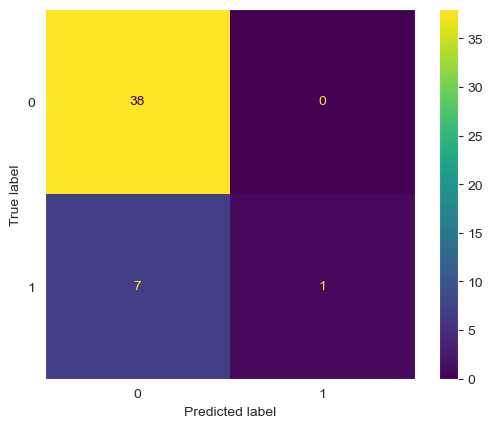

In [91]:
# cycle through the health outcomes
classification_cycler (minhealth_monkey_df)

# REGRESSION CYCLER

In [54]:
### Regression cycler function 
## could be split into seperate functions andd then combine

def cycle_feature_regression_predictions (df):
    
    cat_list = ['ID', 'Species', 'IRRAD', 'SEX', 'TYPE', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD']
    cat_cols = int(input('How many catagorical columns:'))
    
    for (columnName, columnData) in df.iteritems():
        if columnName in  cat_list:
            continue
        else:     
            ### Data Setup ###

            (train_df, test_df)= df, df 

            #data labeling
            ylabel = columnName
            y = df[ylabel]
            X = df.drop(['ID',ylabel],axis=1)

            #declare catagorical features
            cat_features= list(range(0,X[X.columns[:cat_cols]].shape[1]))

            #put data into pool
            pool = Pool(data=X, label=y, cat_features=cat_features)

            #train tesr split
            #test_size = float(input('Test Size'))
            test_size = 0.3
            data= train_test_split(X, y, test_size=test_size, random_state=0)

            #The order of this matters#
            X_train, X_validation, y_train, y_validation= data

            train_pool = Pool(
                data = X_train,
                label = y_train,
                cat_features = cat_features
            )


            validation_pool = Pool(
                data = X_validation,
                label = y_validation,
                cat_features = cat_features
            )

            ### Model Formation ###
            iterations = 1000
            learning_rate = 0.5
            early_stopping_rounds = 2


            model = CatBoostRegressor(iterations=iterations, 
                                      learning_rate=learning_rate,
                                       early_stopping_rounds= early_stopping_rounds
                                     )
            model.fit(X_train,y_train,
                      cat_features=cat_features,
                      verbose=False
                 )

            ### Predictions ###
            a = model.predict(X_validation)
            a_df = pd.DataFrame(a)


            ### Plotting ###
            # Plot the predictions
            fig, ax = plt.subplots()
            ax.scatter(y_validation, a_df)

            ax.plot([y.min(), y.max()], [y.min(), y.max()], 
                    'k-', 
                    linewidth=1, 
                    markersize=120
            )

            #Plot axis titles
            ax.set_xlabel('Actual {}'.format(str(ylabel)))
            ax.set_ylabel('Predicted {}'.format(str(ylabel)))

            #Title of the plot
            #plot_title = input("Plot Title:")
            #show_iters = model.get_param('iterations')  
            ax.set_title("CatBoost %s Predictions" % ylabel
                         ,fontsize=15
            )

            #cordinates for the R2 value box
            xmin, xmax, ymin, ymax = plt.axis()
            yrange = ymax-ymin
            xrange = xmax-xmin


            #Plotting the R2 score and MSE
            ax.annotate("R2: {}".format(str(r2_score(y_validation, a_df).round(2)))+'\nMSE: {}'.format(str(mean_squared_error(y_validation, a_df).round(2))),
                xy=((xmin+(0.1*(xrange))),(ymax-(0.15*(yrange)))), 
                fontsize=12,
                bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}
            )
    

            plt.show() 
            
            #Save the plot
            fig_name = ylabel
            plt.savefig("catboost_cycle_%s.pdf" % fig_name, bbox_inches='tight')

        
            ### Feature Importance ###

            feat = model.get_feature_importance(data=pool,
                               prettified=True,

            )

            print(feat)


In [32]:
# plot the cycled graph in a facet grid – MAY NOT WORK

def facet (df):

    plt.figure(figsize=(15, 12))
    plt.subplots_adjust(hspace=0.2)
    plt.suptitle("Biomarker Predictions", fontsize=18, y=0.95)

    # set number of columns (use 3 to demonstrate the change)
    ncols = 6

    # calculate number of rows
    #nrows = len(tickers) // ncols + (len(tickers) % ncols > 0)
    nrows = 5
    n = 0 
   



    cat_list = ['ID', 'Species', 'IRRAD', 'SEX', 'TYPE', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD']
    cat_cols = 4#int(input('How many catagorical columns:'))
    
    for (columnName, columnData) in df.iteritems():
        if columnName in  cat_list:
            continue
        else:        
            n=n+1
            # add a new subplot iteratively using nrows and cols
            
            
            ax = plt.subplot(nrows, ncols, n+1 )
            ax.scatter(df[columnName],df[columnName])

    

            # filter df and plot ticker on the new subplot axis
            df[columnName].plot(ax=ax)

            # chart formatting
            ax.set_title(columnName.upper())
            #ax.get_legend().remove()
            ax.set_xlabel("")

In [33]:
### make a parent df for the cycler dataset
minbio_monkey_df.copy()
cyclebio_df = minbio_monkey_df

#Exclude datetime feautres
cyclebio_df=cyclebio_df.drop(['IRRAD_DATE','DOB','SAMPLE_DATE'],axis=1)
cyclebio_df['DOSE_(Gy)'] = cyclebio_df['DOSE_(Gy)'].fillna(0)
cyclebio_df.head(2)

,ID,Species,IRRAD,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,MONTHS AT IRRAD,DOSE_(Gy),AGE,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
0,2061,Rhesus-Chinese,No,F,Clinical,NaN,NaN,NaN,0.0,10.6,...,48.0,7.5,0.9,0.1,4742,5232,818,98,11,396
1,2061,Rhesus-Chinese,No,F,Research,NaN,NaN,NaN,0.0,10.7,...,21.4,4.5,0.1,0.0,6512,1883,396,9,0,334


How many catagorical columns: 4


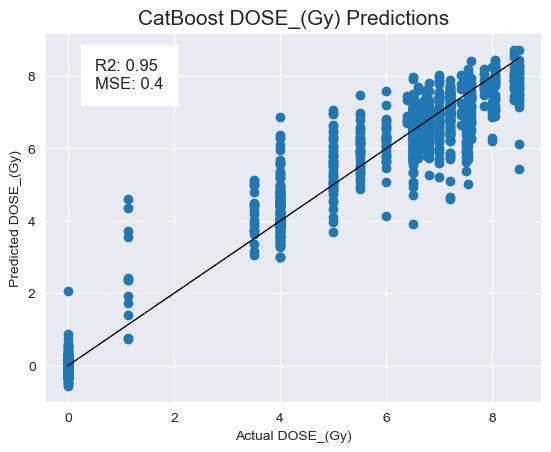

                                           Feature Id  Importances
0                                  MONTHS_SINCE_IRRAD    52.838634
1                                     MONTHS AT IRRAD    25.466664
2                                    DAYS_SINCE_IRRAD     5.794861
3                                                 SEX     2.094320
4                Mean_corpuscular_hemaglobin_(MCH_pg)     1.550753
5                                                 AGE     1.516966
6                                          RBC_(M/uL)     1.430748
7                    Mean_corpuscular_volume_(MCV_fL)     1.420440
8                                PLATLET_COUNT_(K/uL)     0.984636
9                                             Species     0.953250
10                                         WBC_(K/uL)     0.778311
11                                      ABS_EOS_(/uL)     0.727336
12  Mean_corpuscular_hemaglobin_concentration_(MCH...     0.615141
13                                    ABS_LYMPH_(/uL)     0.53

<Figure size 640x480 with 0 Axes>

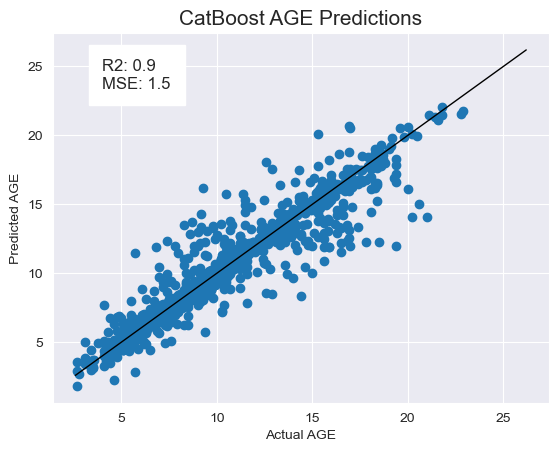

                                           Feature Id  Importances
0                                     MONTHS AT IRRAD    30.976083
1                                    DAYS_SINCE_IRRAD    13.112349
2                                           DOSE_(Gy)    12.407258
3                                  MONTHS_SINCE_IRRAD    12.031168
4                                             Species    10.967439
5                                            MONO_(%)     2.408904
6                                PLATLET_COUNT_(K/uL)     2.148329
7                                                 SEX     2.101515
8                                    Hemocrit_(HCT_%)     1.917453
9                                     ABS_LYMPH_(/uL)     1.582021
10  Mean_corpuscular_hemaglobin_concentration_(MCH...     1.224726
11                              Hemaglobin_(HGB_g/dL)     1.050046
12               Mean_corpuscular_hemaglobin_(MCH_pg)     1.015374
13                                     ABS_MONO_(/uL)     0.91

<Figure size 640x480 with 0 Axes>

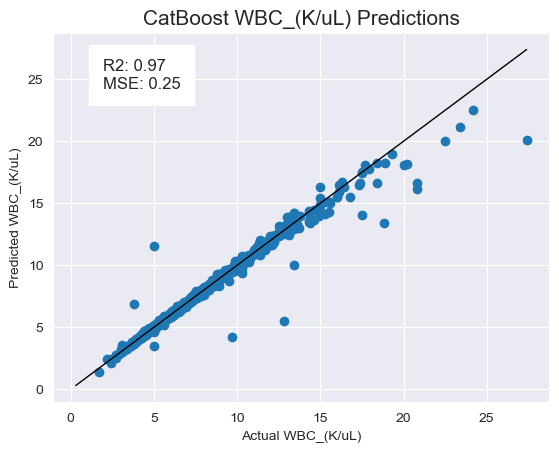

FileNotFoundError: [Errno 2] No such file or directory: 'catboost_cycle_WBC_(K/uL).png'

<Figure size 640x480 with 0 Axes>

In [55]:
#cycle through the biomarkers
cycle_feature_regression_predictions(cyclebio_df)

# OPTOMIZED REGRESSION CYCLER

In [36]:
### function for the data setup in the cycler - aytomates X, y

def cycler_data_setup (df):

    ### Data Setup ###

    (train_df, test_df)= df, df 

    #data labeling
    
    global ylabel, y, X
    ylabel = columnName
    y = df[ylabel]
    X = df.drop(['ID',ylabel],axis=1)

    #declare catagorical features
    global cat_features
    cat_features= list(range(0,X[X.columns[:cat_cols]].shape[1]))

    #put data into pool
    global pool
    pool = Pool(data=X, label=y, cat_features=cat_features)

    #train tesr split
    #test_size = float(input('Test Size'))
    test_size = 0.3
    data= train_test_split(X, y, test_size=test_size, random_state=0)

    #The order of this matters#
    global  X_train, X_validation, y_train, y_validation
    X_train, X_validation, y_train, y_validation= data

    global train_pool
    train_pool = Pool(
        data = X_train,
        label = y_train,
        cat_features = cat_features
    )

    global validation_pool
    validation_pool = Pool(
        data = X_validation,
        label = y_validation,
        cat_features = cat_features
    )


In [37]:
### Plotting function for cycler - automates labels

def cycler_plotter (model, X_validation, y_validation, y):
        ### Plotting ###
    # Plot the predictions
    fig, ax = plt.subplots()
    ax.scatter(y_validation, a_df)

    ax.plot([y.min(), y.max()], [y.min(), y.max()], 
            'k-', 
            linewidth=1, 
            markersize=120
    )

    #Plot axis titles
    ax.set_xlabel('Actual {}'.format(str(ylabel)))
    ax.set_ylabel('Predicted {}'.format(str(ylabel)))

    #Title of the plot
    #plot_title = input("Plot Title:")
    show_iters = model.get_param('iterations')  
    ax.set_title(ylabel + "\nIterations: {}".format(str(show_iters))
                 ,fontsize=15
    )

    #cordinates for the R2 value box
    xmin, xmax, ymin, ymax = plt.axis()
    yrange = ymax-ymin
    xrange = xmax-xmin


    #Plotting the R2 score and MSE
    ax.annotate("R2: {}".format(str(r2_score(y_validation, a_df).round(2)))+'\nMSE: {}'.format(str(mean_squared_error(y_validation, a_df).round(2))),
                xy=((xmin+(0.1*(xrange))),(ymax-(0.15*(yrange)))), 
                fontsize=12,
                bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}
    )
    

    plt.show() 

    ### Feature Importance ###

    feat = model.get_feature_importance(data=pool,
                       prettified=True,

    )

    print(feat)
    

In [38]:
### Tell Optuna what parameters to test

def cycler_objective(trial):
    param = {
        "loss_function": trial.suggest_categorical("loss_function", ["RMSE", "MAE"]),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e0),
        #"iterations" : trial.suggest_int("iterations", 1, 100000), - makes too long/comp really doesn't like it
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 1e0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 20),
        "one_hot_max_size": trial.suggest_int("one_hot_max_size", 2, 20),  
    }
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    model = cb.CatBoostRegressor(**param)

    model.fit(X_train, y_train, cat_features=cat_features, eval_set=[(X_validation, y_validation)], verbose=0, early_stopping_rounds=100)

    global a, a_df
    a = model.predict(X_validation)
    a_df = pd.DataFrame(a)
    accuracy = r2_score(y_validation, a)
    return accuracy


In [39]:
### Make the function for optomized regression cycling

def optomized_regression_cycler (df):
    ##################### for this to work, the catagorical features need to be all to the left side of the df ####################
        
    global cat_cols
    cat_cols = int(input('How many catagorical columns:'))
    cat_list = ['ID', 'Species', 'IRRAD', 'SEX', 'TYPE', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD']   
    
    global columnName, columnData
    for (columnName, columnData) in df.iteritems():
        if columnName in  cat_list:
            continue
        else:     
            cycler_data_setup (df)
            
            optuna.logging.set_verbosity(optuna.logging.WARNING)
            study = optuna.create_study(direction="maximize")
            study.optimize(cycler_objective, n_trials=50, timeout=600)
            trial = study.best_trial
            optuna.logging.set_verbosity(optuna.logging.WARNING)
            
            model = CatBoostRegressor(**trial.params, iterations=1000,early_stopping_rounds=5)
            model.fit(X_train, y_train, cat_features=cat_features, verbose=False)
            
            cycler_plotter (model, X_validation, y_validation, y)


How many catagorical columns: 4


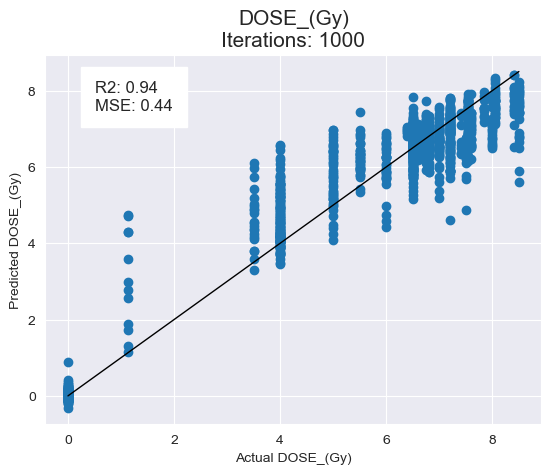

                                           Feature Id  Importances
0                                     MONTHS AT IRRAD    42.056471
1                                  MONTHS_SINCE_IRRAD    19.407454
2                                               IRRAD     8.907920
3                                    DAYS_SINCE_IRRAD     3.810313
4                                                 SEX     3.360301
5                                                 AGE     2.665404
6                                             Species     2.382080
7                Mean_corpuscular_hemaglobin_(MCH_pg)     2.320969
8                                          RBC_(M/uL)     1.655120
9                                    Hemocrit_(HCT_%)     1.581269
10                   Mean_corpuscular_volume_(MCV_fL)     1.489797
11                               PLATLET_COUNT_(K/uL)     1.387175
12                                         WBC_(K/uL)     1.259410
13                              Hemaglobin_(HGB_g/dL)     1.05

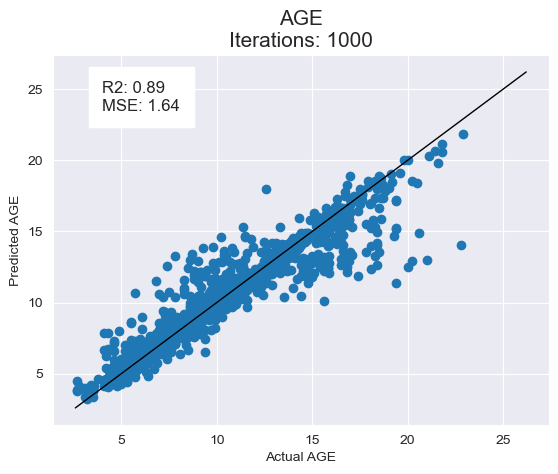

                                           Feature Id  Importances
0                                    DAYS_SINCE_IRRAD    15.627789
1                                  MONTHS_SINCE_IRRAD    15.412656
2                                     MONTHS AT IRRAD    14.762717
3                                               IRRAD    10.421241
4                                           DOSE_(Gy)     7.297110
5                                             Species     7.222939
6                                            MONO_(%)     3.065735
7                                          RBC_(M/uL)     2.526354
8                                     LYMPHOCYTES_(%)     2.442712
9                               Hemaglobin_(HGB_g/dL)     2.393788
10                                         WBC_(K/uL)     1.939452
11                               PLATLET_COUNT_(K/uL)     1.719037
12               Mean_corpuscular_hemaglobin_(MCH_pg)     1.450629
13                   Mean_corpuscular_volume_(MCV_fL)     1.38

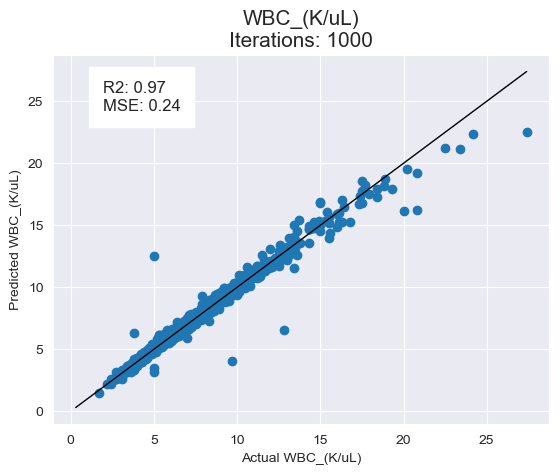

                                           Feature Id  Importances
0                                      ABS_NEUT_(/uL)    43.206223
1                                      ABS_MONO_(/uL)    12.660582
2                                     ABS_LYMPH_(/uL)    12.258767
3                                      ABS_BASO_(/uL)     6.176559
4                                     LYMPHOCYTES_(%)     5.308964
5                                            NEUT_(%)     3.730711
6                                             EOS_(%)     3.550528
7                                            MONO_(%)     2.322997
8                                       ABS_EOS_(/uL)     2.148635
9                                            BASO_(%)     2.089165
10                                          DOSE_(Gy)     1.100443
11                                                AGE     1.074750
12                                 MONTHS_SINCE_IRRAD     0.776039
13                              Hemaglobin_(HGB_g/dL)     0.68

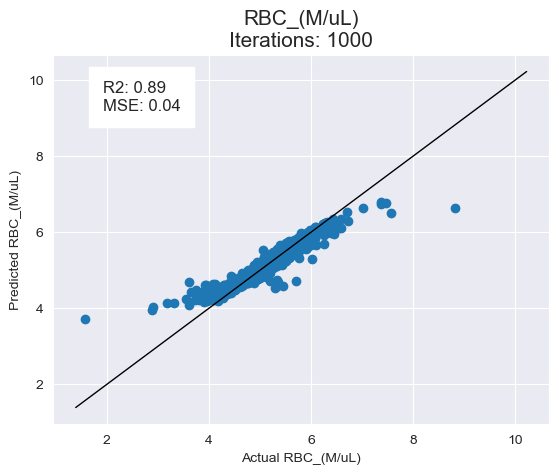

                                           Feature Id  Importances
0                               Hemaglobin_(HGB_g/dL)    32.734695
1                                    Hemocrit_(HCT_%)    31.342808
2                    Mean_corpuscular_volume_(MCV_fL)     9.241793
3                                             Species     7.237171
4                Mean_corpuscular_hemaglobin_(MCH_pg)     7.103853
5                                                 SEX     2.362737
6                                           DOSE_(Gy)     2.039922
7                                     MONTHS AT IRRAD     1.124140
8                                    DAYS_SINCE_IRRAD     0.950769
9                                  MONTHS_SINCE_IRRAD     0.799278
10  Mean_corpuscular_hemaglobin_concentration_(MCH...     0.770389
11                                                AGE     0.726533
12                                              IRRAD     0.633401
13                                    ABS_LYMPH_(/uL)     0.61

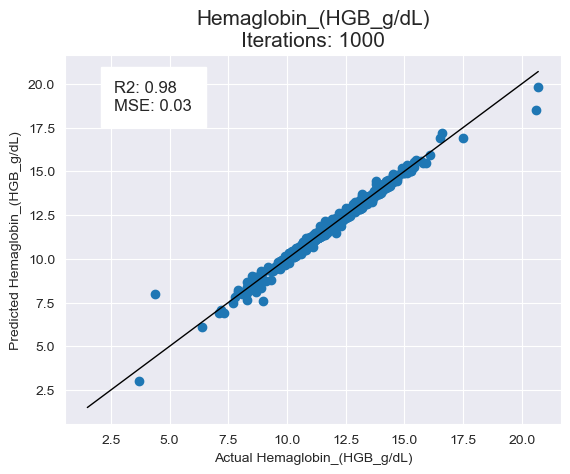

                                           Feature Id  Importances
0                                          RBC_(M/uL)    33.867022
1                                    Hemocrit_(HCT_%)    32.407729
2                Mean_corpuscular_hemaglobin_(MCH_pg)     8.076324
3   Mean_corpuscular_hemaglobin_concentration_(MCH...     6.266644
4                    Mean_corpuscular_volume_(MCV_fL)     4.920312
5                                                 SEX     3.300323
6                                             Species     1.976925
7                                               IRRAD     1.467678
8                                           DOSE_(Gy)     1.392005
9                                    DAYS_SINCE_IRRAD     1.101811
10                               PLATLET_COUNT_(K/uL)     0.913963
11                                    MONTHS AT IRRAD     0.588056
12                                    ABS_LYMPH_(/uL)     0.488376
13                                           MONO_(%)     0.45

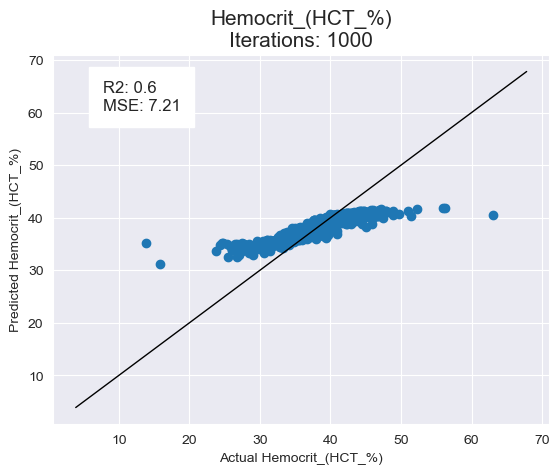

                                           Feature Id  Importances
0                                          RBC_(M/uL)    34.904127
1                               Hemaglobin_(HGB_g/dL)    32.417308
2                    Mean_corpuscular_volume_(MCV_fL)     8.149005
3   Mean_corpuscular_hemaglobin_concentration_(MCH...     4.212238
4                                             Species     2.855804
5                                           DOSE_(Gy)     2.522410
6                Mean_corpuscular_hemaglobin_(MCH_pg)     2.369820
7                                               IRRAD     1.526070
8                                                 AGE     1.447113
9                                                 SEX     1.378021
10                                               TYPE     0.983021
11                               PLATLET_COUNT_(K/uL)     0.963294
12                                      ABS_EOS_(/uL)     0.855795
13                                   DAYS_SINCE_IRRAD     0.69

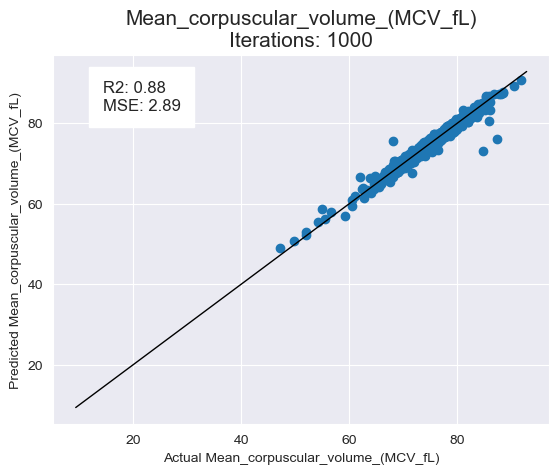

                                           Feature Id  Importances
0                Mean_corpuscular_hemaglobin_(MCH_pg)    36.132997
1   Mean_corpuscular_hemaglobin_concentration_(MCH...    17.874102
2                                          RBC_(M/uL)    10.873411
3                               Hemaglobin_(HGB_g/dL)     9.305488
4                                    Hemocrit_(HCT_%)     6.626952
5                                                TYPE     1.992517
6                                            MONO_(%)     1.859687
7                                PLATLET_COUNT_(K/uL)     1.825057
8                                     MONTHS AT IRRAD     1.320609
9                                      ABS_MONO_(/uL)     1.281503
10                                                AGE     1.192833
11                                          DOSE_(Gy)     1.115489
12                                      ABS_EOS_(/uL)     0.954240
13                                    ABS_LYMPH_(/uL)     0.94

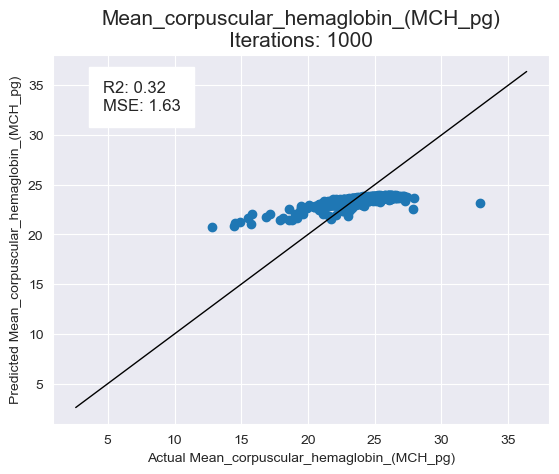

                                           Feature Id  Importances
0                    Mean_corpuscular_volume_(MCV_fL)    34.877205
1   Mean_corpuscular_hemaglobin_concentration_(MCH...    15.214504
2                                          RBC_(M/uL)    12.728290
3                               Hemaglobin_(HGB_g/dL)    11.660381
4                                    Hemocrit_(HCT_%)     7.969993
5                                            NEUT_(%)     1.495611
6                                PLATLET_COUNT_(K/uL)     1.309787
7                                           DOSE_(Gy)     1.273915
8                                            MONO_(%)     1.242029
9                                     ABS_LYMPH_(/uL)     1.240994
10                                                SEX     1.195945
11                                     ABS_MONO_(/uL)     1.191919
12                                    LYMPHOCYTES_(%)     1.125352
13                                                AGE     0.96

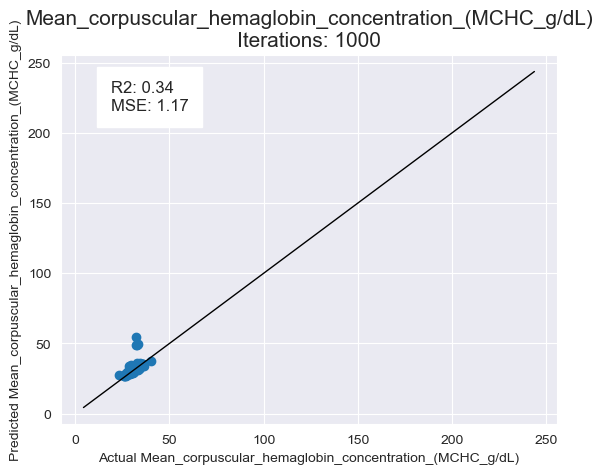

                              Feature Id  Importances
0       Mean_corpuscular_volume_(MCV_fL)    25.655178
1   Mean_corpuscular_hemaglobin_(MCH_pg)    20.561302
2                        MONTHS AT IRRAD    19.155892
3                                Species    10.436710
4                  Hemaglobin_(HGB_g/dL)     5.087195
5                       Hemocrit_(HCT_%)     2.991836
6                                   TYPE     2.427540
7                             RBC_(M/uL)     1.446841
8                         ABS_MONO_(/uL)     1.206206
9                   PLATLET_COUNT_(K/uL)     1.156619
10                              MONO_(%)     1.108621
11                    MONTHS_SINCE_IRRAD     0.905112
12                                   SEX     0.806779
13                              BASO_(%)     0.796983
14                       ABS_LYMPH_(/uL)     0.756028
15                        ABS_NEUT_(/uL)     0.720808
16                               EOS_(%)     0.639318
17                        AB

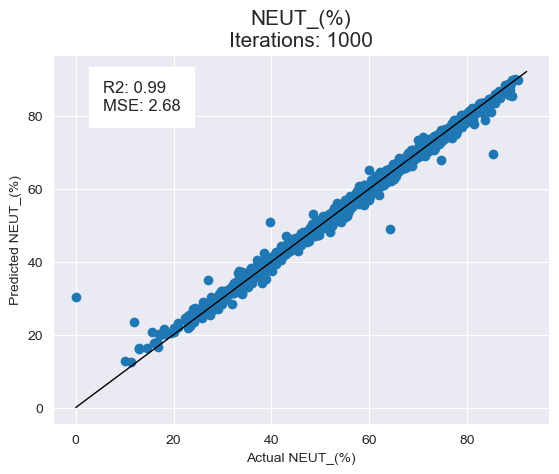

                                           Feature Id  Importances
0                                     LYMPHOCYTES_(%)    56.206517
1                                      ABS_NEUT_(/uL)    18.254733
2                                     ABS_LYMPH_(/uL)    10.967066
3                                          WBC_(K/uL)     2.948111
4                                            MONO_(%)     2.690198
5                                             EOS_(%)     2.320290
6                                       ABS_EOS_(/uL)     1.284941
7                                      ABS_MONO_(/uL)     0.911554
8                                            BASO_(%)     0.646036
9                                PLATLET_COUNT_(K/uL)     0.615668
10                                                AGE     0.533917
11                              Hemaglobin_(HGB_g/dL)     0.368441
12                                               TYPE     0.316293
13                                   DAYS_SINCE_IRRAD     0.26

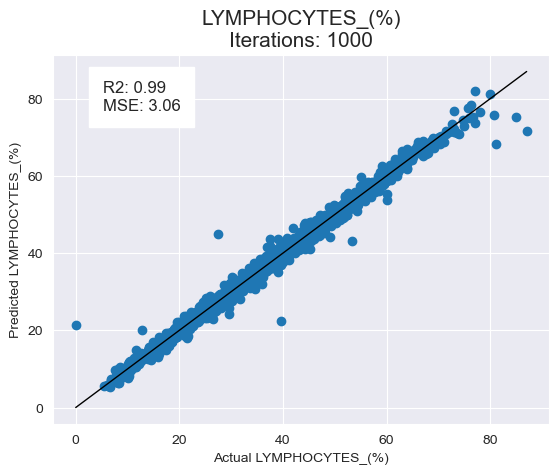

                                           Feature Id  Importances
0                                            NEUT_(%)    35.261770
1                                     ABS_LYMPH_(/uL)    19.419525
2                                      ABS_NEUT_(/uL)    18.136523
3                                          WBC_(K/uL)     7.018026
4                                             EOS_(%)     3.767290
5                                       ABS_EOS_(/uL)     2.666677
6                                            MONO_(%)     1.702732
7                                    DAYS_SINCE_IRRAD     1.448602
8                                      ABS_MONO_(/uL)     1.218450
9                                                 SEX     1.122782
10                                                AGE     1.074541
11                                     ABS_BASO_(/uL)     0.933932
12                                            Species     0.700668
13                                           BASO_(%)     0.69

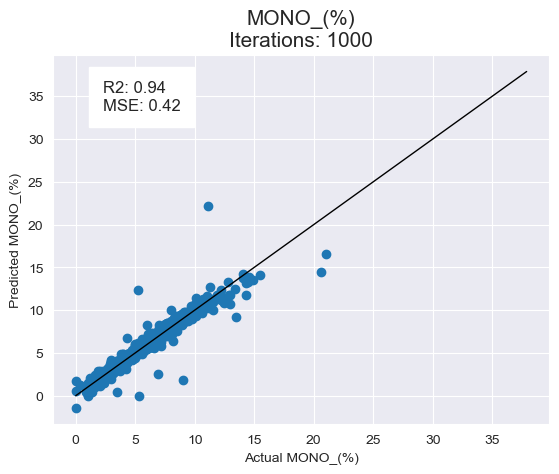

                                           Feature Id  Importances
0                                      ABS_MONO_(/uL)    49.266171
1                                          WBC_(K/uL)    10.665113
2                                      ABS_NEUT_(/uL)     6.221299
3                                            NEUT_(%)     6.120797
4                                     ABS_LYMPH_(/uL)     4.103333
5                                                 AGE     3.927450
6                                  MONTHS_SINCE_IRRAD     3.289139
7                                     LYMPHOCYTES_(%)     2.338041
8                                     MONTHS AT IRRAD     2.250318
9                                             Species     1.670576
10                                   DAYS_SINCE_IRRAD     1.613615
11                                          DOSE_(Gy)     1.398605
12                                         RBC_(M/uL)     0.960743
13                               PLATLET_COUNT_(K/uL)     0.90

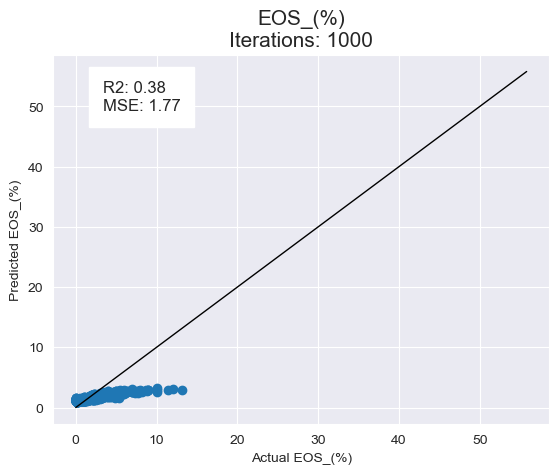

                                           Feature Id  Importances
0                                       ABS_EOS_(/uL)    58.675772
1                                      ABS_NEUT_(/uL)     6.766584
2                                            NEUT_(%)     4.768104
3                                          WBC_(K/uL)     3.809351
4                                    DAYS_SINCE_IRRAD     3.578143
5                                                TYPE     2.594634
6                                     LYMPHOCYTES_(%)     2.198069
7                                             Species     2.171433
8                                     ABS_LYMPH_(/uL)     2.076395
9                                      ABS_BASO_(/uL)     1.976630
10                                 MONTHS_SINCE_IRRAD     1.333905
11                                                AGE     1.128552
12                                     ABS_MONO_(/uL)     1.012770
13               Mean_corpuscular_hemaglobin_(MCH_pg)     0.96

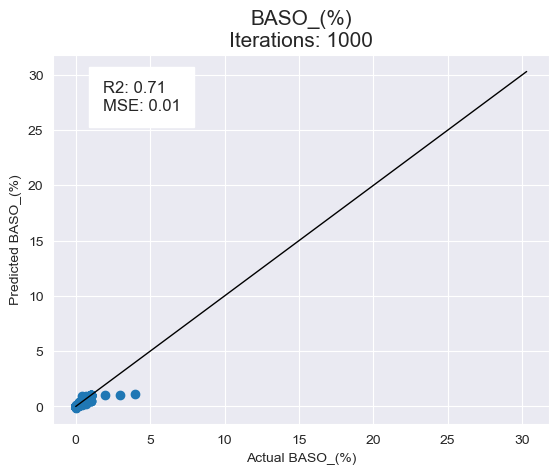

                                           Feature Id  Importances
0                                            NEUT_(%)    38.170429
1                                  MONTHS_SINCE_IRRAD    29.638394
2                    Mean_corpuscular_volume_(MCV_fL)    25.334774
3                                      ABS_BASO_(/uL)     4.393168
4                                          WBC_(K/uL)     0.499004
5                                      ABS_NEUT_(/uL)     0.492144
6                                             Species     0.373603
7                                     ABS_LYMPH_(/uL)     0.212490
8                                      ABS_MONO_(/uL)     0.203144
9                                                 SEX     0.138619
10                               PLATLET_COUNT_(K/uL)     0.075616
11                                   Hemocrit_(HCT_%)     0.074167
12                                    LYMPHOCYTES_(%)     0.069839
13  Mean_corpuscular_hemaglobin_concentration_(MCH...     0.04

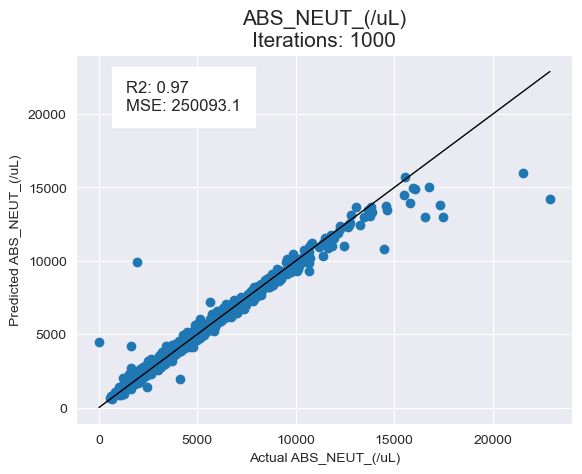

                                           Feature Id  Importances
0                                          WBC_(K/uL)    35.271122
1                                     LYMPHOCYTES_(%)    31.661351
2                                            NEUT_(%)     7.977152
3                                      ABS_BASO_(/uL)     5.812468
4                                     ABS_LYMPH_(/uL)     4.457051
5                                            BASO_(%)     4.311144
6                                      ABS_MONO_(/uL)     2.858193
7                                       ABS_EOS_(/uL)     1.955614
8                                            MONO_(%)     1.754007
9                                             EOS_(%)     1.215385
10                                              IRRAD     0.511315
11                                          DOSE_(Gy)     0.419871
12                                            Species     0.364907
13                                   DAYS_SINCE_IRRAD     0.26

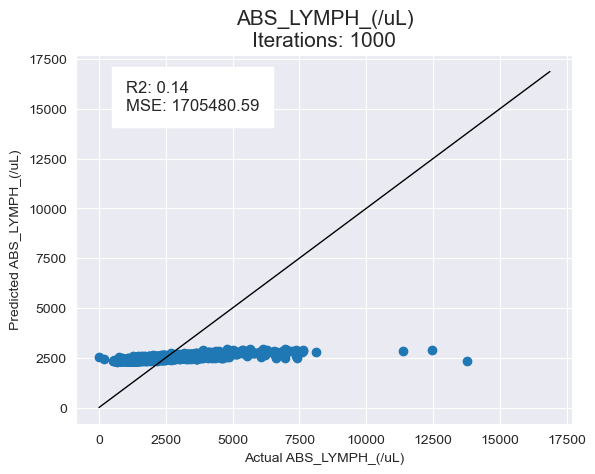

                                           Feature Id  Importances
0                                            NEUT_(%)    29.359155
1                                          WBC_(K/uL)    21.999048
2                                     LYMPHOCYTES_(%)    21.601184
3                                      ABS_NEUT_(/uL)     6.159905
4                                       ABS_EOS_(/uL)     4.077898
5                                      ABS_MONO_(/uL)     2.726148
6                                                 AGE     1.877620
7                                             EOS_(%)     1.428189
8                                            MONO_(%)     1.421654
9                                PLATLET_COUNT_(K/uL)     1.248835
10                                               TYPE     1.188486
11                                     ABS_BASO_(/uL)     1.184262
12                                            Species     0.871119
13                              Hemaglobin_(HGB_g/dL)     0.63

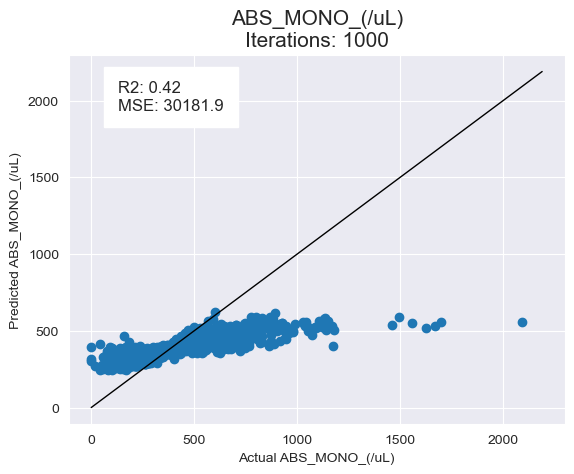

                                           Feature Id  Importances
0                                            MONO_(%)    47.244124
1                                          WBC_(K/uL)    20.424015
2                                     ABS_LYMPH_(/uL)     6.345325
3                                      ABS_NEUT_(/uL)     6.135226
4                                     LYMPHOCYTES_(%)     2.942488
5                                     MONTHS AT IRRAD     2.243671
6                                  MONTHS_SINCE_IRRAD     1.573525
7                                      ABS_BASO_(/uL)     1.363429
8                                           DOSE_(Gy)     1.101693
9                                             Species     1.021773
10                                   DAYS_SINCE_IRRAD     0.911021
11                              Hemaglobin_(HGB_g/dL)     0.909099
12                                           NEUT_(%)     0.878594
13                                      ABS_EOS_(/uL)     0.86

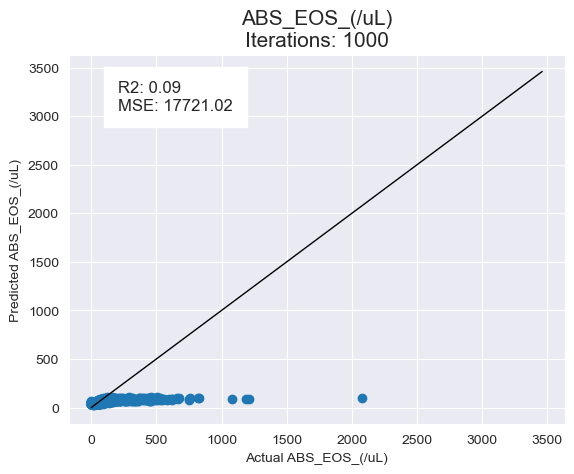

                                           Feature Id  Importances
0                                             EOS_(%)    50.456930
1                                      ABS_NEUT_(/uL)     6.101553
2                                          WBC_(K/uL)     5.747066
3                                            NEUT_(%)     3.674828
4                                     ABS_LYMPH_(/uL)     3.588417
5                                           DOSE_(Gy)     2.537145
6                                          RBC_(M/uL)     2.531625
7                                    DAYS_SINCE_IRRAD     2.302584
8                                  MONTHS_SINCE_IRRAD     2.242648
9                                                 AGE     2.168379
10                                     ABS_MONO_(/uL)     1.962846
11               Mean_corpuscular_hemaglobin_(MCH_pg)     1.940655
12                                    LYMPHOCYTES_(%)     1.866789
13                                     ABS_BASO_(/uL)     1.67

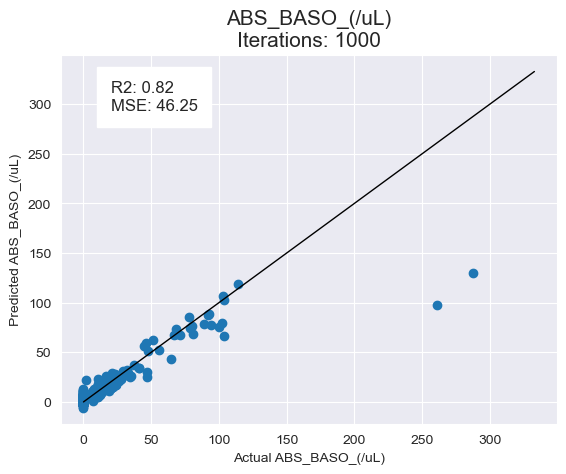

                                           Feature Id  Importances
0                                            BASO_(%)    62.092879
1                                          WBC_(K/uL)     6.048522
2                                      ABS_NEUT_(/uL)     3.270503
3                                     ABS_LYMPH_(/uL)     2.797094
4                                      ABS_MONO_(/uL)     2.699241
5                                            NEUT_(%)     2.459477
6   Mean_corpuscular_hemaglobin_concentration_(MCH...     2.402456
7                                             EOS_(%)     1.864022
8                    Mean_corpuscular_volume_(MCV_fL)     1.657650
9                                PLATLET_COUNT_(K/uL)     1.534797
10                                         RBC_(M/uL)     1.494167
11                                      ABS_EOS_(/uL)     1.452454
12                                           MONO_(%)     1.405285
13                                   DAYS_SINCE_IRRAD     1.30

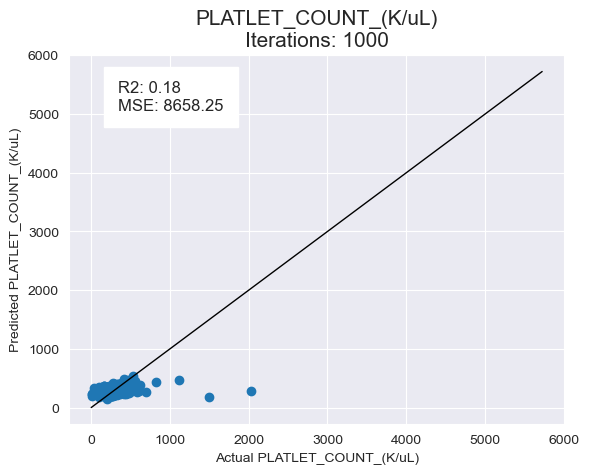

                                           Feature Id  Importances
0                                      ABS_MONO_(/uL)    11.578761
1                                                 AGE     8.940321
2   Mean_corpuscular_hemaglobin_concentration_(MCH...     7.278571
3                                            MONO_(%)     6.726691
4                                     ABS_LYMPH_(/uL)     6.174863
5                Mean_corpuscular_hemaglobin_(MCH_pg)     5.383780
6                                          WBC_(K/uL)     4.616044
7                                           DOSE_(Gy)     4.374330
8                                     MONTHS AT IRRAD     4.349471
9                    Mean_corpuscular_volume_(MCV_fL)     3.798814
10                              Hemaglobin_(HGB_g/dL)     3.473775
11                                   DAYS_SINCE_IRRAD     3.428068
12                                              IRRAD     3.214699
13                                     ABS_NEUT_(/uL)     2.87

In [40]:
# Cycling thorugh predictions that use the optomized moddels
optomized_regression_cycler (cyclebio_df)

# Input your own data
Be able to input values for irrad features and have the model make predictions based on just that - trained on multi monkey data

# Single Monkey Preditions, whole data

In [31]:
#make a parent df
single_minbio_df.copy()
sreg_df = single_minbio_df

#Exclude datetime feautres
sreg_df=sreg_df.drop(['IRRAD_DATE','DOB','SAMPLE_DATE'],axis=1)
sreg_df.head(2)


,ID,Species,IRRAD,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,MONTHS AT IRRAD,DOSE_(Gy),AGE,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
33,2046,Rhesus-Chinese,Yes,F,Clinical,1303.0,43.0,81.0,1.14,10.3,...,44.6,5.5,0.5,0.0,1877,1695,209,19,0,276
34,2046,Rhesus-Chinese,Yes,F,Clinical,1344.0,44.0,81.0,1.14,10.4,...,40.5,7.4,0.0,0.0,3647,2835,518,0,0,386


In [36]:
### Make the single monkey train/test data

#make train/testdf
(sreg_train_df, sreg_test_df)= sreg_df, sreg_df


# label values extraction
sreg_y=sreg_train_df['LYMPHOCYTES_(%)']
sreg_X=sreg_train_df.drop(['ID','LYMPHOCYTES_(%)'],axis=1)


# Declare catagorical features - first column
cat_features= list(range(0,sreg_X[sreg_X.columns[:4]].shape[1]))

print(cat_features)

# all of our labels are catagorical

#put the data into the pool
sreg_pool = Pool(data=sreg_X, label=sreg_y, cat_features=cat_features)


#train tesr split - 30% test
sreg_data= train_test_split(sreg_X, sreg_y, test_size=0.3, random_state=0)

#### The order of this matters###
sreg_X_train, sreg_X_validation,sreg_y_train, sreg_y_validation= sreg_data

sreg_train_pool = Pool(
    data = sreg_X_train,
    label = sreg_y_train,
    cat_features = cat_features
)

sreg_validation_pool = Pool(
    data = sreg_X_validation,
    label = sreg_y_validation,
    cat_features = cat_features
)

[0, 1, 2, 3]


In [37]:
### Make the multi monkey train/test data

#make train/testdf
(oneless_train_df, oneless_test_df)= oneless_df, oneless_df


# label values extraction
oneless_y=oneless_train_df['LYMPHOCYTES_(%)']
oneless_X=oneless_train_df.drop(['ID','IRRAD_DATE','DOB','SAMPLE_DATE','LYMPHOCYTES_(%)'],axis=1)


# Declare catagorical features - first & second column
cat_features= list(range(0,oneless_X[oneless_X.columns[:4]].shape[1]))
print(cat_features)


#put the data into the pool
oneless_pool = Pool(data=oneless_X, label=oneless_y, cat_features=cat_features)


#train tesr split - 30% test
oneless_data= train_test_split(oneless_X, oneless_y, test_size=0.3, random_state=0)


#### The order of this matters###
oneless_X_train, oneless_X_validation, oneless_y_train, oneless_y_validation= oneless_data

oneless_train_pool = Pool(
    data = oneless_X_train,
    label = oneless_y_train,
    cat_features = cat_features
)

oneless_validation_pool = Pool(
    data = oneless_X_validation,
    label = oneless_y_validation,
    cat_features = cat_features
)


[0, 1, 2, 3]


In [42]:
### Making a model with the same perameters but without the single monkey data
# regression for multiple monkey predicitons
model= CatBoostRegressor(iterations=100,
    learning_rate=0.5,
    early_stopping_rounds=5
)


model.fit(oneless_X_validation, 
           oneless_y_validation, 
           cat_features=cat_features, 
           verbose=100 #tells how many iterations to print
         )


0:	learn: 9.6611725	total: 6.49ms	remaining: 642ms
99:	learn: 0.3481126	total: 290ms	remaining: 0us


Plot Title: Single Monkey Lymphocyte Predictions Using Multi Monkey Data
Figure name cat-sm-lymph


                                           Feature Id  Importances
0                                            NEUT_(%)    60.903066
1                                     ABS_LYMPH_(/uL)    16.263334
2                                      ABS_NEUT_(/uL)     9.951429
3                                      ABS_MONO_(/uL)     3.511722
4                                                 AGE     3.280961
5                                       ABS_EOS_(/uL)     1.919550
6                                            MONO_(%)     1.504251
7                                          RBC_(M/uL)     0.444218
8                                             EOS_(%)     0.356882
9                    Mean_corpuscular_volume_(MCV_fL)     0.281737
10  Mean_corpuscular_hemaglobin_concentration_(MCH...     0.251502
11                                           BASO_(%)     0.247967
12                               PLATLET_COUNT_(K/uL)     0.212927
13                                   DAYS_SINCE_IRRAD     0.19

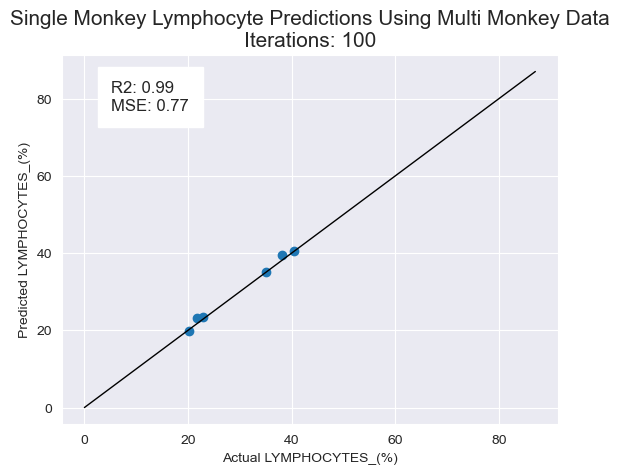

In [43]:
# Single Monkey Lymphocyte Predictions Using Multi Monkey Data
predict_and_plot(model, sreg_X_validation, sreg_y_validation, y)

# Multi Monkey Predictions, whole data

In [22]:
#make a parent df
minbio_monkey_df.copy()
mreg_df = minbio_monkey_df

#Exclude datetime feautres
mreg_df=mreg_df.drop(['IRRAD_DATE','DOB','SAMPLE_DATE'],axis=1)
mreg_df.head(5)


,ID,Species,IRRAD,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,MONTHS AT IRRAD,DOSE_(Gy),AGE,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
0,2061,Rhesus-Chinese,No,F,Clinical,NaN,NaN,NaN,NaN,10.6,...,48.0,7.5,0.9,0.1,4742,5232,818,98,11,396
1,2061,Rhesus-Chinese,No,F,Research,NaN,NaN,NaN,NaN,10.7,...,21.4,4.5,0.1,0.0,6512,1883,396,9,0,334
2,2061,Rhesus-Chinese,No,F,Research,NaN,NaN,NaN,NaN,10.9,...,8.5,3.4,0.1,0.1,15383,1488,595,18,18,321
3,2061,Rhesus-Chinese,No,F,Research,NaN,NaN,NaN,NaN,11.3,...,5.5,2.7,0.1,0.0,19349,1161,570,21,0,310
4,2061,Rhesus-Chinese,No,F,Research,NaN,NaN,NaN,NaN,11.6,...,14.5,6.6,0.1,0.0,9062,1668,759,12,0,486


Target Feature Column: LYMPHOCYTES_(%)
How many catagorical columns: 4
Test Size 0.5
Iterations: 1000
Learning Rate: 0.5
Stopping Rounds: 1000
Plot Title: Multi Monkey Lymphocytes
Figure name cat-multi-1000iter


                                           Feature Id  Importances
0                                            NEUT_(%)    78.777396
1                                     ABS_LYMPH_(/uL)     6.449728
2                                            MONO_(%)     4.063107
3                                             EOS_(%)     2.723993
4                                      ABS_MONO_(/uL)     1.996256
5                                      ABS_NEUT_(/uL)     1.339675
6                                          WBC_(K/uL)     1.139071
7                                            BASO_(%)     0.672702
8                               Hemaglobin_(HGB_g/dL)     0.493333
9                                    DAYS_SINCE_IRRAD     0.486571
10                                      ABS_EOS_(/uL)     0.419762
11               Mean_corpuscular_hemaglobin_(MCH_pg)     0.343020
12  Mean_corpuscular_hemaglobin_concentration_(MCH...     0.162831
13                   Mean_corpuscular_volume_(MCV_fL)     0.16

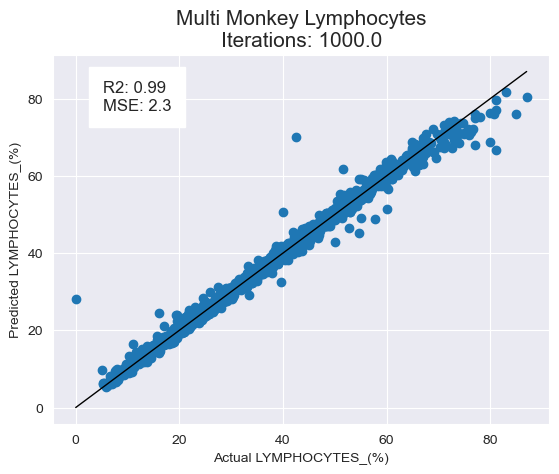

In [26]:
# Multi Monkey Lymphocytes
regression_pipeline(mreg_df)

Target Feature Column: LYMPHOCYTES_(%)
How many catagorical columns: 4
Test Size 0.3
Do you want this potomized? (1/0) 1
Plot Title: Multi Monkey Lymphocytes: Optomized
Figure name cat-multi-opt


                                           Feature Id  Importances
0                                            NEUT_(%)    45.380345
1                                     ABS_LYMPH_(/uL)    24.750948
2                                      ABS_NEUT_(/uL)    12.364661
3                                          WBC_(K/uL)     4.714328
4                                             EOS_(%)     2.643406
5                                      ABS_MONO_(/uL)     1.605858
6                                       ABS_EOS_(/uL)     1.226114
7                                                 AGE     1.222873
8                                            MONO_(%)     1.039857
9                                                 SEX     0.595206
10                                           BASO_(%)     0.505983
11                                   DAYS_SINCE_IRRAD     0.470499
12                                 MONTHS_SINCE_IRRAD     0.451166
13                                   Hemocrit_(HCT_%)     0.39

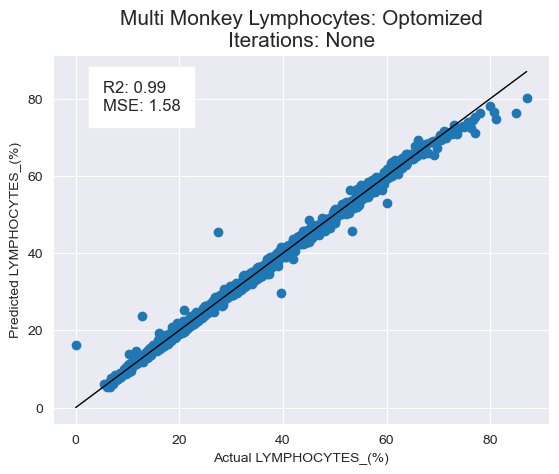

In [30]:
#Multi Monkey Lymphocytes: Optomized
opomized_regression_pipeline (mreg_df)

## Prediction of biomarkers

### A. Predictions using only the top 5 important features
top 5 features found in section 1.a. Using the top 5 features found from each model (single v. multi monkey)

#### Single Monkey:
Top 5 features: 
- 0	NEUT_(%)	25.791263
- 1	TYPE	13.162456
- 2	ABS_LYMPH_(/uL)	13.094777
- 3	EOS_(%)	11.994731
- 4	RBC_(M/uL)	11.799281
- 5	Hemocrit_(HCT_%)	4.794531
- 6	Mean_corpuscular_hemaglobin_concentration_(MCH...	4.392843

- Use non-lymphocyte related features: independence

Target Feature Column: LYMPHOCYTES_(%)
How many catagorical columns: 1
Test Size 0.5
Iterations: 1000
Learning Rate: 05
Stopping Rounds: 5


learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


Plot Title: t
Figure name f


                                          Feature Id  Importances
0                                           NEUT_(%)    87.595360
1                                         RBC_(M/uL)    11.005741
2  Mean_corpuscular_hemaglobin_concentration_(MCH...     0.709294
3                                               TYPE     0.586027
4                                   Hemocrit_(HCT_%)     0.103579
5                                            EOS_(%)     0.000000


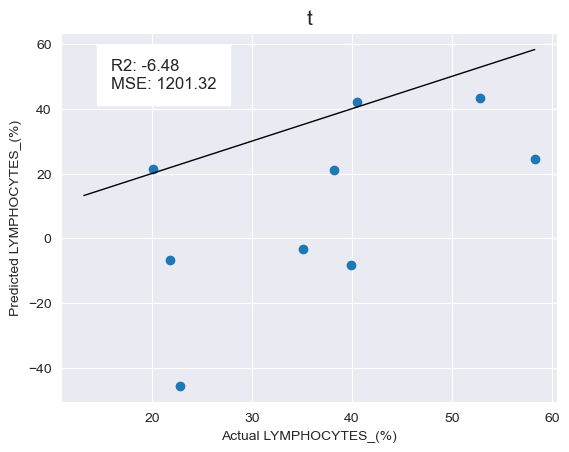

In [55]:
### Make the reduced df

#make a parent df
single_minbio_df.copy()
sred_reg_df = single_minbio_df[['ID', 'TYPE', 'NEUT_(%)', #'ABS_LYMPH_(/uL)',
                                'EOS_(%)','RBC_(M/uL)',
                                'LYMPHOCYTES_(%)']]


# Predicting Sinlge Monkey Lymphocyte Using 5 Features
regression_pipeline(sred_reg_df)

#### Multi Monkey
Top 5 features:
- 0	NEUT_(%)	86.690265
- 1	ABS_LYMPH_(/uL)	4.309505
- 2	ABS_MONO_(/uL)	2.908496
- 3	MONO_(%)	2.536824
- 4	EOS_(%)	1.749061
- 5	ABS_EOS_(/uL)	0.948118
- 6	Hemaglobin_(HGB_g/dL)	0.429481

- Use non-lymphocyte related features: independence

Target Feature Column: LYMPHOCYTES_(%)
How many catagorical columns: 0
Test Size 0.3
Iterations: 1000
Learning Rate: 0.5
Stopping Rounds: 5
Plot Title: Predicting Mulit Monkey Lymphocyte Using 5 Features
Figure name cat-multi-5


              Feature Id  Importances
0               NEUT_(%)    91.589077
1               MONO_(%)     3.099477
2                EOS_(%)     2.287977
3         ABS_MONO_(/uL)     2.228533
4  Hemaglobin_(HGB_g/dL)     0.794935


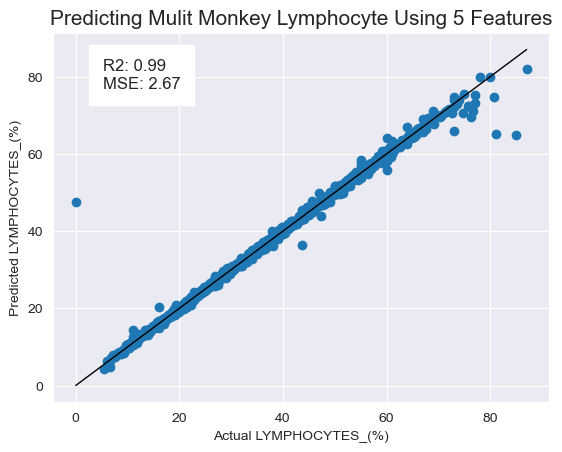

In [52]:
### Make the reduced df

#make a parent df
minbio_monkey_df.copy()
mred_reg_df = minbio_monkey_df[['ID', 'NEUT_(%)', 'ABS_MONO_(/uL)', 'MONO_(%)', #'ABS_LYMPH_(/uL)',
                                'EOS_(%)','Hemaglobin_(HGB_g/dL)', 'LYMPHOCYTES_(%)']]



# Predicting Mulit Monkey Lymphocyte Using 5 Features
regression_pipeline(mred_reg_df)


### B. Predicting lymphocytes with only the radiation data


#### Multi Monkey only
No variation for single monkey model formation

Target Feature Column: LYMPHOCYTES_(%)
How many catagorical columns: 2
Test Size 0.3
Iterations: 1000
Learning Rate: 0.5
Stopping Rounds: 5
Plot Title: Lymphocyte Predictions Using Radiation Data
Figure name cat-irrad-lymph


           Feature Id  Importances
0                 AGE    24.957066
1     MONTHS AT IRRAD    22.116224
2           DOSE_(Gy)    20.255731
3    DAYS_SINCE_IRRAD    19.332496
4  MONTHS_SINCE_IRRAD     8.640869
5                 SEX     4.697613
6               IRRAD     0.000000


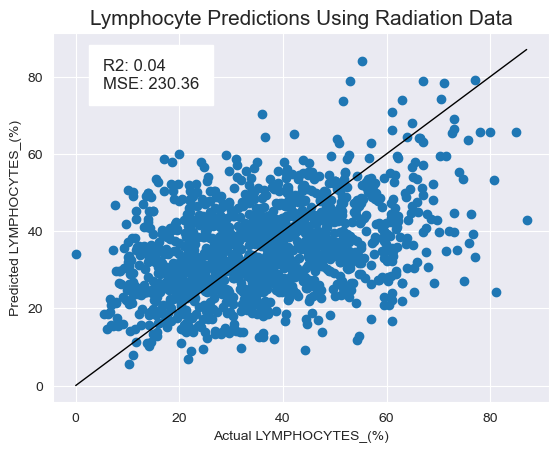

In [57]:
### Make the radiation df

#make a parent df
minbio_monkey_df.copy()
mrad_reg_df = minbio_monkey_df[['ID', 'IRRAD', 'SEX', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD',
       'DOSE_(Gy)', 'AGE', 'LYMPHOCYTES_(%)']]


# Lymphocyte Predictions Using Radiation Data
regression_pipeline(mrad_reg_df)

## Predictions of the health outcomes


### A. Multi Monkey using only top 5 features

- 0	NEUT_(%)	86.690265
- 1	ABS_LYMPH_(/uL)	4.309505
- 2	ABS_MONO_(/uL)	2.908496
- 3	MONO_(%)	2.536824
- 4	EOS_(%)	1.749061
- 5	ABS_EOS_(/uL)	0.948118
- 6	Hemaglobin_(HGB_g/dL)	0.429481

- Use non-lymphocyte related features: independence

Target Feature Column: Tumor_(Y/N)
How many catagorical columns: 0
Test Size 0.3
Iterations: 1000
Learning Rate: 0.5
Stopping Rounds: 5
Figure name Classification of Tumorigenesis Using 5 Features


Accuracy: 0.782608695652174 Precision: 0.3333333333333333
              precision    recall  f1-score   support

           0       0.81      0.95      0.88        37
           1       0.33      0.11      0.17         9

    accuracy                           0.78        46
   macro avg       0.57      0.53      0.52        46
weighted avg       0.72      0.78      0.74        46



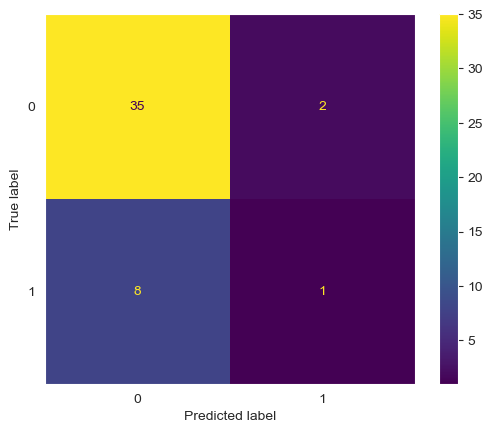

In [74]:
#### Make the reduced df

#make a parent df
minhealth_monkey_df.copy()
five_health_df = minhealth_monkey_df[['ID', 'Dose_(Gy)', 'Heart_(Y/N)', 'Time_Under_Observation_(yrs)',
                                'Overweight_(Y/N)','Years_Since_Irrad', 'Tumor_(Y/N)']]

# Classification of Tumorigenesis Using 5 Features
classifier_pipeline (five_health_df)

### B. Multi monkey with only the radiation data

Target Feature Column: Tumor_(Y/N)
How many catagorical columns: 0
Test Size 0.3
Iterations: 1000
Learning Rate: 0.5
Stopping Rounds: 5
Figure name Classification of Tumorigenesis Using Radiation Data


Accuracy: 0.6956521739130435 Precision: 0.14285714285714285
              precision    recall  f1-score   support

           0       0.79      0.84      0.82        37
           1       0.14      0.11      0.12         9

    accuracy                           0.70        46
   macro avg       0.47      0.47      0.47        46
weighted avg       0.67      0.70      0.68        46



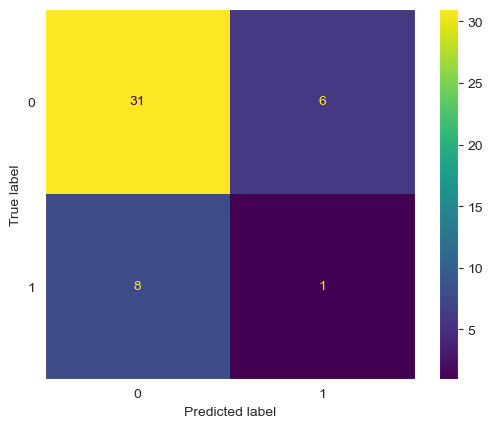

In [75]:
### Make the radiation df

#make a parent df
minhealth_monkey_df.copy()
rad_health_df = minhealth_monkey_df[['ID', 'Dose_(Gy)', 'Irrad_Age_(months)',
                                           'Years_Since_Irrad', 'Current_Age_(years)', 'Tumor_(Y/N)']]

# Classification of Tumorigenesis Using Radiation Data
classifier_pipeline (rad_health_df)

Target Feature Column: Tumor_(Y/N)
How many catagorical columns: 0
Test Size 0.3
Iterations: 100000
Learning Rate: 0.5
Stopping Rounds: 5
Figure name Classification of Tumorigenesis


Accuracy: 0.782608695652174 Precision: 0.42857142857142855
              precision    recall  f1-score   support

           0       0.85      0.89      0.87        37
           1       0.43      0.33      0.38         9

    accuracy                           0.78        46
   macro avg       0.64      0.61      0.62        46
weighted avg       0.76      0.78      0.77        46



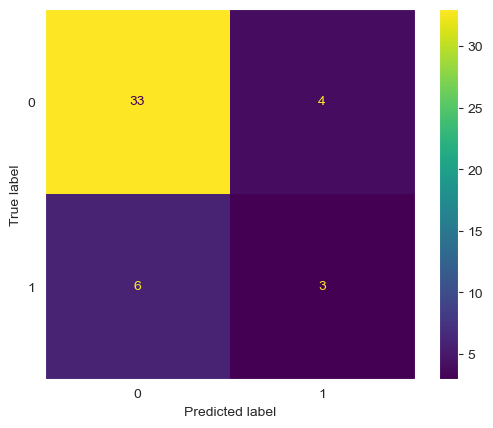

In [92]:
#Classification of Tumorigenesis
classifier_pipeline (minhealth_monkey_df)

## Predicting dose 

In [58]:
#make single monkey df
single_minbio_df.copy()
single_dose_df = single_minbio_df

#fill na values to 0
single_dose_df[['DOSE_(Gy)']]= single_dose_df[['DOSE_(Gy)']].fillna(0, #inplace=True
)



#make multi monkey df
minbio_monkey_df.copy()
dose_df = minbio_monkey_df

#fill na values to 0
dose_df[['DOSE_(Gy)']]= dose_df[['DOSE_(Gy)']].fillna(0, #inplace=True
)

dose_df = dose_df.drop(['IRRAD_DATE','DOB','SAMPLE_DATE'],axis=1)

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
4547    0.0
4548    0.0
4549    0.0
4550    0.0
4551    0.0
Name: DOSE_(Gy), Length: 4552, dtype: float64

Target Feature Column: DOSE_(Gy)
How many catagorical columns: 4
Test Size 0.3
Iterations: 1000
Learning Rate: 0.5
Stopping Rounds: 5
Plot Title: Multi Monkey Dose (Gy) Predictions
Figure name cat-dose


                                           Feature Id  Importances
0                                  MONTHS_SINCE_IRRAD    52.838634
1                                     MONTHS AT IRRAD    25.466664
2                                    DAYS_SINCE_IRRAD     5.794861
3                                                 SEX     2.094320
4                Mean_corpuscular_hemaglobin_(MCH_pg)     1.550753
5                                                 AGE     1.516966
6                                          RBC_(M/uL)     1.430748
7                    Mean_corpuscular_volume_(MCV_fL)     1.420440
8                                PLATLET_COUNT_(K/uL)     0.984636
9                                             Species     0.953250
10                                         WBC_(K/uL)     0.778311
11                                      ABS_EOS_(/uL)     0.727336
12  Mean_corpuscular_hemaglobin_concentration_(MCH...     0.615141
13                                    ABS_LYMPH_(/uL)     0.53

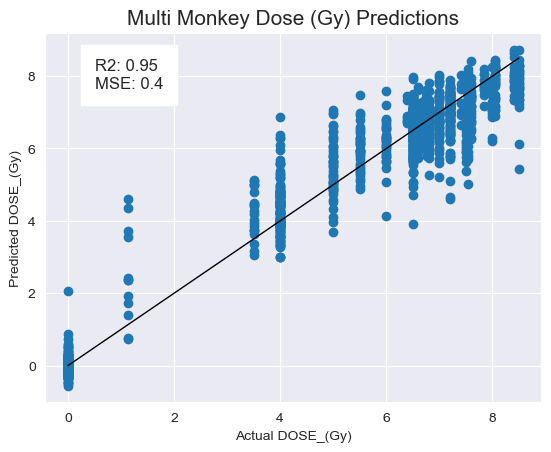

In [61]:
#predicting dose
regression_pipeline(dose_df)

# Input your own data
Be able to input values for irrad features and have the model make predictions based on just that - trained on multi monkey data

In [31]:
def my_health_api (li):
    vector = []
    vector2 = ['age','dose','days','months','age_at']
    age = float(input('Age (yr)'))
    vector.append(age)
    
    
    dose = float(input('Radiation dose (Gy)'))
    vector.append(dose)
    
    
    days = float(input('Days since exposure'))
    vector.append(days)
    
    
    months = float(input('Months since exposure'))
    vector.append(months)
    
    
    age_at = float(input('Age at exposure (mo)'))
    vector.append(months)
    

    
    df = pd.DataFrame(data=vector, columns=vector2)
    
    #print(a)
    print(df.head())

In [32]:
vector = []
my_health_api (vector)


Age (yr) 5
Radiation dose (Gy) 5
Days since exposure 10
Months since exposure 0
Age at exposure (mo) 5


ValueError: Shape of passed values is (5, 1), indices imply (5, 5)

In [ ]:
vector2 = ['age','dose','days','months','age_at']
print(vector
     )